# 3D Spiral Experiment: ODE2VAE

In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.distributions import MultivariateNormal, Normal, kl_divergence as kl
from torch_bnn import BNN

In [2]:
def generate_spiral3d(nspiral=1000,
                      ntotal=1000,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys, orig_ts), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys, orig_ts), axis=1)

    if savefig:
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(orig_traj_cw[:, 0], orig_traj_cw[:, 1], orig_traj_cw[:, 2], label='clock')
        ax.plot3D(orig_traj_cc[:, 0], orig_traj_cc[:, 1], orig_traj_cc[:, 2], label='counter clock')
        plt.legend()
        plt.show()
        plt.close()

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

In [3]:
class ODE2VAE(nn.Module):
    def __init__(self, q, Hf, He, Hd):
        super(ODE2VAE, self).__init__()
        # encoder
        self.q = q
        self.Hf = Hf
        self.He = He
        self.Hd = Hd

        self.encoder = nn.Sequential(
            nn.Linear(3, He),
            nn.Tanh(),
            nn.Linear(He, He),
            nn.Tanh()
        )

        self.fc1 = nn.Linear(He, 2*q)
        self.fc2 = nn.Linear(He, 2*q)
        # differential function
        # to use a deterministic differential function, set bnn=False and self.beta=0.0
        self.bnn = BNN(2*q, q, n_hid_layers=2, n_hidden=self.Hf, act='tanh', layer_norm=True, bnn=True)
        # downweighting the BNN KL term is helpful if self.bnn is heavily overparameterized
        self.beta = 2*q/self.bnn.kl().numel()
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(Hd, Hd),
            nn.Tanh(),
            nn.Linear(Hd, 3),
            nn.Sigmoid()
        )
        self.fc3 = nn.Linear(q, Hd)

        self._zero_mean = torch.zeros(2*q).to(device)
        self._eye_covar = torch.eye(2*q).to(device) 
        self.mvn = MultivariateNormal(self._zero_mean, self._eye_covar)

    def ode2vae_rhs(self,t,vs_logp,f):
        vs, logp = vs_logp # N,2q & N
        q = vs.shape[1]//2
        dv = f(vs) # N,q 
        ds = vs[:,:q]  # N,q
        dvs = torch.cat([dv,ds],1) # N,2q
        ddvi_dvi = torch.stack(
                    [torch.autograd.grad(dv[:,i],vs,torch.ones_like(dv[:,i]),
                    retain_graph=True,create_graph=True)[0].contiguous()[:,i]
                    for i in range(q)],1) # N,q --> df(x)_i/dx_i, i=1..q
        tr_ddvi_dvi = torch.sum(ddvi_dvi,1) # N
        return (dvs,-tr_ddvi_dvi)

    def elbo(self, qz_m, qz_logv, zode_L, logpL, X, XrecL, Ndata, qz_enc_m=None, qz_enc_logv=None):
        ''' Input:
                qz_m        - latent means [N,2q]
                qz_logv     - latent logvars [N,2q]
                zode_L      - latent trajectory samples [L,N,T,2q]
                logpL       - densities of latent trajectory samples [L,N,T]
                X           - input images [N,T,nc,d,d]
                XrecL       - reconstructions [L,N,T,nc,d,d]
                Ndata       - number of sequences in the dataset (required for elbo
                qz_enc_m    - encoder density means  [N*T,2*q]
                qz_enc_logv - encoder density variances [N*T,2*q]
            Returns:
                likelihood
                prior on ODE trajectories KL[q_ode(z_{0:T})||N(0,I)]
                prior on BNN weights
                instant encoding term KL[q_ode(z_{0:T})||q_enc(z_{0:T}|X_{0:T})] (if required) 
        '''
        [N,T,d] = X.shape
        L = zode_L.shape[0]
        q = qz_m.shape[1]//2
        # prior
        log_pzt = self.mvn.log_prob(zode_L.contiguous().view([L*N*T,2*q])) # L*N*T
        log_pzt = log_pzt.view([L,N,T]) # L,N,T
        kl_zt   = logpL - log_pzt  # L,N,T
        kl_z    = kl_zt.sum(2).mean(0) # N
        kl_w    = self.bnn.kl().sum()
        # likelihood
        XL = X.repeat([L,1,1,1]) # L,N,T,nc,d,d 
        lhood_L = torch.log(1e-3+XrecL)*XL + torch.log(1e-3+1-XrecL)*(1-XL) # L,N,T,nc,d,d
        lhood = lhood_L.sum([2,3]).mean(0) # N
        if qz_enc_m is not None: # instant encoding
            qz_enc_mL    = qz_enc_m.repeat([L,1])  # L*N*T,2*q
            qz_enc_logvL = qz_enc_logv.repeat([L,1])  # L*N*T,2*q
            mean_ = qz_enc_mL.contiguous().view(-1) # L*N*T*2*q
            std_  = 1e-3+qz_enc_logvL.exp().contiguous().view(-1) # L*N*T*2*q
            qenc_zt_ode = Normal(mean_,std_).log_prob(zode_L.contiguous().view(-1)).view([L,N,T,2*q])
            qenc_zt_ode = qenc_zt_ode.sum([3]) # L,N,T
            inst_enc_KL = logpL - qenc_zt_ode
            inst_enc_KL = inst_enc_KL.sum(2).mean(0) # N
            return Ndata*lhood.mean(), Ndata*kl_z.mean(), kl_w, Ndata*inst_enc_KL.mean()
        else:
            return Ndata*lhood.mean(), Ndata*kl_z.mean(), kl_w

    def forward(self, X, ts, Ndata, L=1, inst_enc=False, method='dopri5', dt=0.1):
        ''' Input
                X          - input images [N,T,nc,d,d]
                Ndata      - number of sequences in the dataset (required for elbo)
                L          - number of Monta Carlo draws (from BNN)
                inst_enc   - whether instant encoding is used or not
                method     - numerical integration method
                dt         - numerical integration step size 
            Returns
                Xrec_mu    - reconstructions from the mean embedding - [N,nc,D,D]
                Xrec_L     - reconstructions from latent samples     - [L,N,nc,D,D]
                qz_m       - mean of the latent embeddings           - [N,q]
                qz_logv    - log variance of the latent embeddings   - [N,q]
                lhood-kl_z - ELBO   
                lhood      - reconstruction likelihood
                kl_z       - KL
        '''
        # encode
        [N,T,d] = X.shape
        h = self.encoder(X[:, 0])
        qz0_m, qz0_logv = self.fc1(h), self.fc2(h) # N,2q & N,2q
        q = qz0_m.shape[1]//2
        # latent samples
        eps = torch.randn_like(qz0_m)  # N,2q
        z0 = qz0_m + eps*torch.exp(qz0_logv) # N,2q
        logp0 = self.mvn.log_prob(eps) # N 
        # ODE
        t = ts
        ztL = []
        logpL = []
        # sample L trajectories
        for _ in range(L):
            f = self.bnn.draw_f() # draw a differential function
            oderhs = lambda t,vs: self.ode2vae_rhs(t,vs,f) # make the ODE forward function
            zt, logp = odeint(oderhs,(z0,logp0),t,method=method) # T,N,2q & T,N
            ztL.append(zt.permute([1,0,2]).unsqueeze(0)) # 1,N,T,2q
            logpL.append(logp.permute([1,0]).unsqueeze(0)) # 1,N,T
        ztL = torch.cat(ztL,0) # L,N,T,2q
        logpL = torch.cat(logpL) # L,N,T
        # decode
        st_muL = ztL[:,:,:,q:] # L,N,T,q
        s = self.fc3(st_muL.contiguous().view([L*N*T, q])) # L*N*T,h_dim
        Xrec = self.decoder(s) # L*N*T,nc,d,d
        Xrec = Xrec.view([L,N,T,d]) # L,N,T,nc,d,d
        # likelihood and elbo
        if inst_enc:
            h = self.encoder(X.contiguous().view([N*T,d]))
            qz_enc_m, qz_enc_logv = self.fc1(h), self.fc2(h) # N*T,2q & N*T,2q
            lhood, kl_z, kl_w, inst_KL = \
                self.elbo(qz0_m, qz0_logv, ztL, logpL, X, Xrec, Ndata, qz_enc_m, qz_enc_logv)
            elbo = lhood - kl_z - inst_KL - self.beta*kl_w
        else:
            lhood, kl_z, kl_w = self.elbo(qz0_m, qz0_logv, ztL, logpL, X, Xrec, Ndata)
            elbo = lhood - kl_z - self.beta*kl_w
        return Xrec, qz0_m, qz0_logv, ztL, elbo, lhood, kl_z, self.beta*kl_w

    def mean_rec(self, X, method='dopri5', dt=0.1):
        [N,T,d] = X.shape
        # encode
        h = self.encoder(X[:, 0])
        qz0_m = self.fc1(h) # N,2q
        q = qz0_m.shape[1]//2
        # ode
        def ode2vae_mean_rhs(t,vs,f):
            q = vs.shape[1]//2
            dv = f(vs) # N,q 
            ds = vs[:,:q]  # N,q
            return torch.cat([dv,ds],1) # N,2q
        f = self.bnn.draw_f(mean=True) # use the mean differential function
        odef = lambda t,vs: ode2vae_mean_rhs(t,vs,f) # make the ODE forward function

        ts_pos = np.linspace(0., 2. * np.pi, num=2000)
        ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()

        t_pos = torch.from_numpy(ts_pos).float().to(qz0_m.device)
        t_neg = torch.from_numpy(ts_neg).float().to(qz0_m.device)

        zs_pos = odeint(odef, qz0_m, t_pos, method=method).permute([1, 0, 2])
        zs_neg = odeint(odef, qz0_m, t_neg, method=method).permute([1, 0, 2])

        st_pos = zs_pos[:,:,q:] # N,T,q
        st_neg = zs_neg[:,:,q:] # N,T,q

        s_pos = self.fc3(st_pos.contiguous().view([2000, q]))
        s_neg = self.fc3(st_neg.contiguous().view([2000, q]))
        xs_pos = self.decoder(s_pos)
        xs_pos = xs_pos.view([2000, d])
        xs_neg = torch.flip(self.decoder(s_neg), dims=[0])
        xs_neg = xs_neg.view([2000, d])

        return xs_pos, xs_neg


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

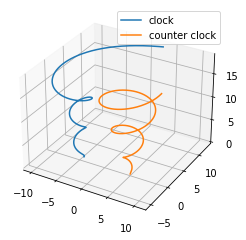

In [4]:
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100
batch_size = 1000

# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral3d(
    nspiral=nspiral,
    start=start,
    stop=stop,
    noise_std=noise_std,
    a=a, b=b,
    ntotal=ntotal,
    nsample=nsample
)

train_dset = torch.utils.data.TensorDataset(torch.from_numpy(samp_trajs).float())
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size)

Iter:0  lhood: -245.04  kl_z:532.72    kl_w:   15.14
Epoch:   1/5000 tr_elbo: 1299.63
Iter:0  lhood: -237.50  kl_z:515.88    kl_w:   15.14
Epoch:   2/5000 tr_elbo: 1225.14
Iter:0  lhood: -220.39  kl_z:807.42    kl_w:   15.14
Epoch:   3/5000 tr_elbo: 1788.65
Iter:0  lhood: -222.63  kl_z:507.57    kl_w:   15.14
Epoch:   4/5000 tr_elbo: 1132.69
Iter:0  lhood: -209.37  kl_z:527.87    kl_w:   15.14
Epoch:   5/5000 tr_elbo: 1254.13
Iter:0  lhood: -215.46  kl_z:480.84    kl_w:   15.14
Epoch:   6/5000 tr_elbo: 1158.20
Iter:0  lhood: -211.43  kl_z:588.77    kl_w:   15.14
Epoch:   7/5000 tr_elbo: 1379.10
Iter:0  lhood: -174.19  kl_z:507.34    kl_w:   15.14
Epoch:   8/5000 tr_elbo: 1255.34
Iter:0  lhood: -185.55  kl_z:487.77    kl_w:   15.14
Epoch:   9/5000 tr_elbo: 1145.45
Iter:0  lhood: -224.13  kl_z:492.87    kl_w:   15.14


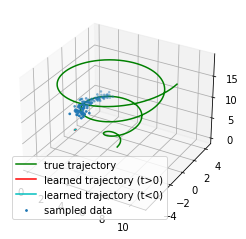

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  10/5000 tr_elbo: 1186.00
Iter:0  lhood: -211.95  kl_z:514.71    kl_w:   15.14
Epoch:  11/5000 tr_elbo: 1311.25
Iter:0  lhood: -183.87  kl_z:646.68    kl_w:   15.14
Epoch:  12/5000 tr_elbo: 1419.94
Iter:0  lhood: -194.50  kl_z:448.71    kl_w:   15.14
Epoch:  13/5000 tr_elbo: 1087.69
Iter:0  lhood: -214.98  kl_z:409.99    kl_w:   15.14
Epoch:  14/5000 tr_elbo: 1016.05
Iter:0  lhood: -216.03  kl_z:490.00    kl_w:   15.14
Epoch:  15/5000 tr_elbo: 1208.99
Iter:0  lhood: -177.13  kl_z:488.00    kl_w:   15.14
Epoch:  16/5000 tr_elbo: 1149.04
Iter:0  lhood: -197.37  kl_z:513.71    kl_w:   15.14
Epoch:  17/5000 tr_elbo: 1257.90
Iter:0  lhood: -201.00  kl_z:381.04    kl_w:   15.14
Epoch:  18/5000 tr_elbo:  918.96
Iter:0  lhood: -178.58  kl_z:598.71    kl_w:   15.14
Epoch:  19/5000 tr_elbo: 1336.47
Iter:0  lhood: -179.03  kl_z:388.74    kl_w:   15.14


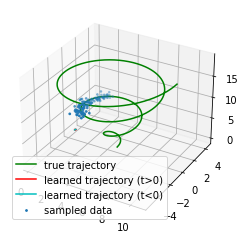

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  20/5000 tr_elbo:  976.91
Iter:0  lhood: -175.95  kl_z:423.41    kl_w:   15.14
Epoch:  21/5000 tr_elbo: 1011.65
Iter:0  lhood: -156.13  kl_z:514.33    kl_w:   15.14
Epoch:  22/5000 tr_elbo: 1217.72
Iter:0  lhood: -198.86  kl_z:451.34    kl_w:   15.14
Epoch:  23/5000 tr_elbo: 1050.82
Iter:0  lhood: -213.49  kl_z:393.21    kl_w:   15.14
Epoch:  24/5000 tr_elbo:  940.50
Iter:0  lhood: -181.15  kl_z:386.43    kl_w:   15.14
Epoch:  25/5000 tr_elbo:  882.08
Iter:0  lhood: -155.49  kl_z:416.61    kl_w:   15.14
Epoch:  26/5000 tr_elbo:  958.81
Iter:0  lhood: -143.14  kl_z:444.87    kl_w:   15.14
Epoch:  27/5000 tr_elbo:  959.53
Iter:0  lhood: -130.58  kl_z:488.80    kl_w:   15.14
Epoch:  28/5000 tr_elbo: 1073.31
Iter:0  lhood: -149.42  kl_z:398.71    kl_w:   15.14
Epoch:  29/5000 tr_elbo:  949.52
Iter:0  lhood: -142.66  kl_z:618.35    kl_w:   15.14


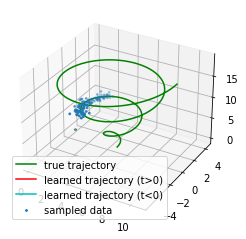

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  30/5000 tr_elbo: 1363.20
Iter:0  lhood: -122.03  kl_z:465.19    kl_w:   15.14
Epoch:  31/5000 tr_elbo: 1048.21
Iter:0  lhood: -112.14  kl_z:465.26    kl_w:   15.14
Epoch:  32/5000 tr_elbo: 1027.34
Iter:0  lhood: -153.65  kl_z:302.83    kl_w:   15.14
Epoch:  33/5000 tr_elbo:  745.25
Iter:0  lhood: -177.33  kl_z:462.29    kl_w:   15.14
Epoch:  34/5000 tr_elbo: 1061.10
Iter:0  lhood: -121.67  kl_z:417.77    kl_w:   15.14
Epoch:  35/5000 tr_elbo:  973.91
Iter:0  lhood: -128.90  kl_z:299.60    kl_w:   15.14
Epoch:  36/5000 tr_elbo:  694.55
Iter:0  lhood: -160.57  kl_z:253.41    kl_w:   15.14
Epoch:  37/5000 tr_elbo:  641.08
Iter:0  lhood: -132.48  kl_z:359.67    kl_w:   15.14
Epoch:  38/5000 tr_elbo:  879.23
Iter:0  lhood: -145.41  kl_z:408.25    kl_w:   15.14
Epoch:  39/5000 tr_elbo:  985.68
Iter:0  lhood: -139.88  kl_z:393.07    kl_w:   15.14


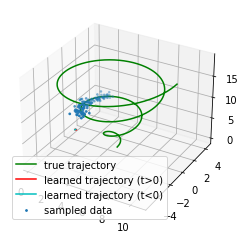

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  40/5000 tr_elbo:  934.89
Iter:0  lhood: -137.15  kl_z:481.05    kl_w:   15.14
Epoch:  41/5000 tr_elbo: 1058.54
Iter:0  lhood: -177.06  kl_z:334.83    kl_w:   15.14
Epoch:  42/5000 tr_elbo:  778.02
Iter:0  lhood: -169.37  kl_z:324.10    kl_w:   15.14
Epoch:  43/5000 tr_elbo:  785.64
Iter:0  lhood: -102.88  kl_z:336.82    kl_w:   15.14
Epoch:  44/5000 tr_elbo:  748.53
Iter:0  lhood: -102.37  kl_z:335.78    kl_w:   15.14
Epoch:  45/5000 tr_elbo:  755.65
Iter:0  lhood: -130.88  kl_z:383.33    kl_w:   15.14
Epoch:  46/5000 tr_elbo:  901.37
Iter:0  lhood: -124.89  kl_z:319.20    kl_w:   15.14
Epoch:  47/5000 tr_elbo:  766.62
Iter:0  lhood: -108.26  kl_z:299.81    kl_w:   15.14
Epoch:  48/5000 tr_elbo:  715.61
Iter:0  lhood: -109.19  kl_z:346.93    kl_w:   15.14
Epoch:  49/5000 tr_elbo:  805.12
Iter:0  lhood: -123.08  kl_z:351.21    kl_w:   15.14


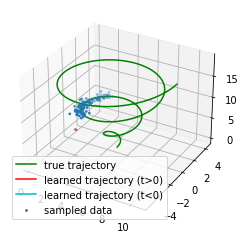

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  50/5000 tr_elbo:  835.28
Iter:0  lhood: -103.93  kl_z:216.62    kl_w:   15.14
Epoch:  51/5000 tr_elbo:  578.56
Iter:0  lhood:  -81.83  kl_z:286.67    kl_w:   15.14
Epoch:  52/5000 tr_elbo:  690.14
Iter:0  lhood: -102.03  kl_z:313.61    kl_w:   15.14
Epoch:  53/5000 tr_elbo:  714.89
Iter:0  lhood: -108.76  kl_z:368.36    kl_w:   15.14
Epoch:  54/5000 tr_elbo:  867.34
Iter:0  lhood: -136.21  kl_z:277.87    kl_w:   15.14
Epoch:  55/5000 tr_elbo:  655.56
Iter:0  lhood: -125.72  kl_z:286.94    kl_w:   15.14
Epoch:  56/5000 tr_elbo:  682.09
Iter:0  lhood: -115.72  kl_z:426.48    kl_w:   15.14
Epoch:  57/5000 tr_elbo:  958.91
Iter:0  lhood:  -93.48  kl_z:226.85    kl_w:   15.14
Epoch:  58/5000 tr_elbo:  552.60
Iter:0  lhood:  -74.18  kl_z:310.04    kl_w:   15.14
Epoch:  59/5000 tr_elbo:  760.14
Iter:0  lhood: -103.15  kl_z:247.30    kl_w:   15.14


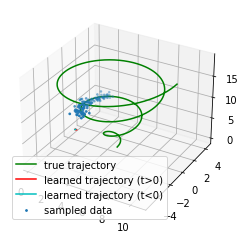

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  60/5000 tr_elbo:  600.80
Iter:0  lhood:  -65.91  kl_z:303.57    kl_w:   15.14
Epoch:  61/5000 tr_elbo:  706.57
Iter:0  lhood:  -57.40  kl_z:284.64    kl_w:   15.14
Epoch:  62/5000 tr_elbo:  622.03
Iter:0  lhood:  -61.31  kl_z:572.31    kl_w:   15.14
Epoch:  63/5000 tr_elbo: 1227.86
Iter:0  lhood:  -81.63  kl_z:217.98    kl_w:   15.14
Epoch:  64/5000 tr_elbo:  542.40
Iter:0  lhood:  -61.99  kl_z:229.65    kl_w:   15.14
Epoch:  65/5000 tr_elbo:  531.99
Iter:0  lhood:  -68.55  kl_z:180.43    kl_w:   15.14
Epoch:  66/5000 tr_elbo:  420.39
Iter:0  lhood:  -90.50  kl_z:523.43    kl_w:   15.14
Epoch:  67/5000 tr_elbo: 1133.20
Iter:0  lhood:  -73.98  kl_z:273.91    kl_w:   15.14
Epoch:  68/5000 tr_elbo:  597.89
Iter:0  lhood:  -52.27  kl_z:231.79    kl_w:   15.14
Epoch:  69/5000 tr_elbo:  540.06
Iter:0  lhood:  -77.81  kl_z:249.07    kl_w:   15.14


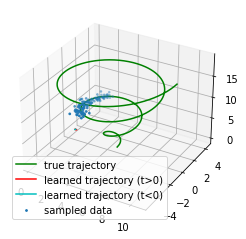

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  70/5000 tr_elbo:  608.74
Iter:0  lhood:  -63.99  kl_z:240.59    kl_w:   15.14
Epoch:  71/5000 tr_elbo:  568.24
Iter:0  lhood:  -54.63  kl_z:260.58    kl_w:   15.14
Epoch:  72/5000 tr_elbo:  600.61
Iter:0  lhood:  -90.75  kl_z:227.71    kl_w:   15.14
Epoch:  73/5000 tr_elbo:  582.73
Iter:0  lhood:  -28.11  kl_z:356.73    kl_w:   15.14
Epoch:  74/5000 tr_elbo:  773.44
Iter:0  lhood:  -28.97  kl_z:419.65    kl_w:   15.14
Epoch:  75/5000 tr_elbo:  916.19
Iter:0  lhood:  -54.45  kl_z:247.52    kl_w:   15.14
Epoch:  76/5000 tr_elbo:  554.25
Iter:0  lhood:  -74.91  kl_z:290.01    kl_w:   15.14
Epoch:  77/5000 tr_elbo:  673.75
Iter:0  lhood:  -50.91  kl_z:365.69    kl_w:   15.14
Epoch:  78/5000 tr_elbo:  803.39
Iter:0  lhood:    4.56  kl_z:226.79    kl_w:   15.14
Epoch:  79/5000 tr_elbo:  446.09
Iter:0  lhood:  -19.81  kl_z:207.12    kl_w:   15.14


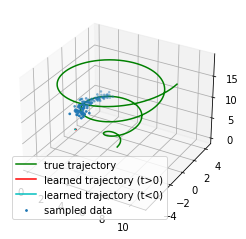

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  80/5000 tr_elbo:  461.16
Iter:0  lhood:   -9.83  kl_z:216.48    kl_w:   15.14
Epoch:  81/5000 tr_elbo:  464.49
Iter:0  lhood:  -48.33  kl_z:188.56    kl_w:   15.14
Epoch:  82/5000 tr_elbo:  438.20
Iter:0  lhood:  -42.47  kl_z:282.07    kl_w:   15.14
Epoch:  83/5000 tr_elbo:  610.76
Iter:0  lhood:  -37.38  kl_z:112.46    kl_w:   15.14
Epoch:  84/5000 tr_elbo:  278.75
Iter:0  lhood:  -32.40  kl_z:177.76    kl_w:   15.14
Epoch:  85/5000 tr_elbo:  402.39
Iter:0  lhood:  -16.77  kl_z:260.07    kl_w:   15.14
Epoch:  86/5000 tr_elbo:  567.92
Iter:0  lhood:  -68.87  kl_z:311.07    kl_w:   15.14
Epoch:  87/5000 tr_elbo:  704.12
Iter:0  lhood:  -51.13  kl_z:157.77    kl_w:   15.14
Epoch:  88/5000 tr_elbo:  371.55
Iter:0  lhood:   15.70  kl_z:227.93    kl_w:   15.14
Epoch:  89/5000 tr_elbo:  441.70
Iter:0  lhood:    4.68  kl_z:236.31    kl_w:   15.14


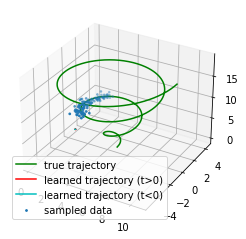

Stored ckpt at ./ckpt_ode2vae.pth
Epoch:  90/5000 tr_elbo:  490.38
Iter:0  lhood:  -21.74  kl_z:150.97    kl_w:   15.14
Epoch:  91/5000 tr_elbo:  353.53
Iter:0  lhood:  -11.85  kl_z:229.95    kl_w:   15.14
Epoch:  92/5000 tr_elbo:  473.05
Iter:0  lhood:  -25.29  kl_z:181.58    kl_w:   15.14
Epoch:  93/5000 tr_elbo:  420.32
Iter:0  lhood:    5.58  kl_z:151.23    kl_w:   15.14
Epoch:  94/5000 tr_elbo:  308.76
Iter:0  lhood:   65.80  kl_z:278.69    kl_w:   15.14
Epoch:  95/5000 tr_elbo:  537.57
Iter:0  lhood:   -6.80  kl_z:238.90    kl_w:   15.14
Epoch:  96/5000 tr_elbo:  491.72
Iter:0  lhood:   31.69  kl_z:165.90    kl_w:   15.14
Epoch:  97/5000 tr_elbo:  331.72
Iter:0  lhood:    6.91  kl_z:192.26    kl_w:   15.14
Epoch:  98/5000 tr_elbo:  382.95
Iter:0  lhood:   39.23  kl_z:258.24    kl_w:   15.14
Epoch:  99/5000 tr_elbo:  486.79
Iter:0  lhood:   40.98  kl_z:197.30    kl_w:   15.14


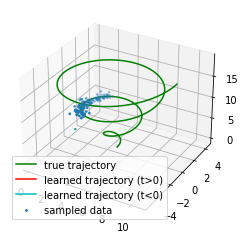

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 100/5000 tr_elbo:  344.44
Iter:0  lhood:   52.67  kl_z:206.64    kl_w:   15.14
Epoch: 101/5000 tr_elbo:  372.90
Iter:0  lhood:   -1.29  kl_z:264.83    kl_w:   15.14
Epoch: 102/5000 tr_elbo:  609.98
Iter:0  lhood:   42.32  kl_z:246.07    kl_w:   15.14
Epoch: 103/5000 tr_elbo:  492.31
Iter:0  lhood:    5.32  kl_z:191.82    kl_w:   15.14
Epoch: 104/5000 tr_elbo:  381.32
Iter:0  lhood:   33.93  kl_z:189.85    kl_w:   15.14
Epoch: 105/5000 tr_elbo:  400.67
Iter:0  lhood:   17.78  kl_z:224.05    kl_w:   15.14
Epoch: 106/5000 tr_elbo:  466.19
Iter:0  lhood:   58.20  kl_z:236.73    kl_w:   15.14
Epoch: 107/5000 tr_elbo:  418.34
Iter:0  lhood:   35.23  kl_z:116.52    kl_w:   15.14
Epoch: 108/5000 tr_elbo:  197.07
Iter:0  lhood:   10.13  kl_z:169.93    kl_w:   15.14
Epoch: 109/5000 tr_elbo:  330.00
Iter:0  lhood:   68.45  kl_z:200.51    kl_w:   15.14


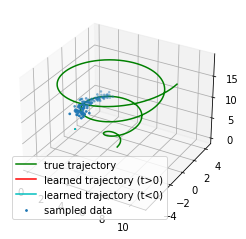

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 110/5000 tr_elbo:  346.69
Iter:0  lhood:   30.12  kl_z:222.05    kl_w:   15.14
Epoch: 111/5000 tr_elbo:  492.03
Iter:0  lhood:   44.56  kl_z:155.58    kl_w:   15.14
Epoch: 112/5000 tr_elbo:  265.45
Iter:0  lhood:  100.63  kl_z:151.93    kl_w:   15.14
Epoch: 113/5000 tr_elbo:  217.51
Iter:0  lhood:   56.80  kl_z:239.83    kl_w:   15.14
Epoch: 114/5000 tr_elbo:  427.89
Iter:0  lhood:  127.19  kl_z:219.68    kl_w:   15.14
Epoch: 115/5000 tr_elbo:  352.78
Iter:0  lhood:   54.67  kl_z:109.28    kl_w:   15.14
Epoch: 116/5000 tr_elbo:  196.89
Iter:0  lhood:   80.77  kl_z:274.81    kl_w:   15.14
Epoch: 117/5000 tr_elbo:  485.34
Iter:0  lhood:   66.89  kl_z:240.04    kl_w:   15.14
Epoch: 118/5000 tr_elbo:  471.34
Iter:0  lhood:   56.37  kl_z:257.42    kl_w:   15.14
Epoch: 119/5000 tr_elbo:  456.88
Iter:0  lhood:   79.05  kl_z:192.28    kl_w:   15.14


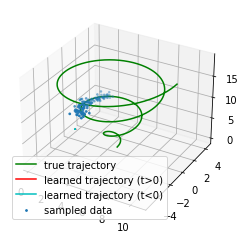

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 120/5000 tr_elbo:  354.51
Iter:0  lhood:  106.99  kl_z:146.55    kl_w:   15.14
Epoch: 121/5000 tr_elbo:  247.57
Iter:0  lhood:   98.97  kl_z:150.42    kl_w:   15.14
Epoch: 122/5000 tr_elbo:  230.65
Iter:0  lhood:   86.09  kl_z:130.82    kl_w:   15.14
Epoch: 123/5000 tr_elbo:  181.25
Iter:0  lhood:   48.67  kl_z:132.39    kl_w:   15.14
Epoch: 124/5000 tr_elbo:  200.98
Iter:0  lhood:   83.92  kl_z:192.52    kl_w:   15.14
Epoch: 125/5000 tr_elbo:  321.82
Iter:0  lhood:  117.59  kl_z:139.45    kl_w:   15.14
Epoch: 126/5000 tr_elbo:  209.79
Iter:0  lhood:  187.48  kl_z:300.99    kl_w:   15.14
Epoch: 127/5000 tr_elbo:  423.36
Iter:0  lhood:   72.71  kl_z:213.51    kl_w:   15.14
Epoch: 128/5000 tr_elbo:  348.92
Iter:0  lhood:  123.10  kl_z:101.67    kl_w:   15.14
Epoch: 129/5000 tr_elbo:   95.29
Iter:0  lhood:  118.88  kl_z:68.63     kl_w:   15.14


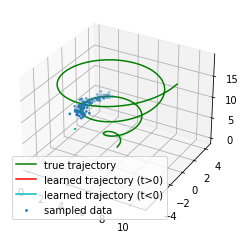

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 130/5000 tr_elbo:   60.27
Iter:0  lhood:  132.70  kl_z:213.50    kl_w:   15.14
Epoch: 131/5000 tr_elbo:  326.30
Iter:0  lhood:  191.77  kl_z:133.77    kl_w:   15.14
Epoch: 132/5000 tr_elbo:   93.45
Iter:0  lhood:  213.95  kl_z:219.05    kl_w:   15.14
Epoch: 133/5000 tr_elbo:  228.80
Iter:0  lhood:  137.66  kl_z:136.66    kl_w:   15.14
Epoch: 134/5000 tr_elbo:  131.07
Iter:0  lhood:  155.52  kl_z:127.53    kl_w:   15.14
Epoch: 135/5000 tr_elbo:  126.32
Iter:0  lhood:  204.04  kl_z:195.03    kl_w:   15.14
Epoch: 136/5000 tr_elbo:  217.87
Iter:0  lhood:  186.65  kl_z:134.06    kl_w:   15.14
Epoch: 137/5000 tr_elbo:   50.35
Iter:0  lhood:  144.11  kl_z:171.09    kl_w:   15.14
Epoch: 138/5000 tr_elbo:  180.54
Iter:0  lhood:  188.65  kl_z:218.46    kl_w:   15.14
Epoch: 139/5000 tr_elbo:  249.35
Iter:0  lhood:  175.77  kl_z:177.97    kl_w:   15.14


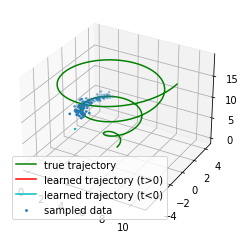

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 140/5000 tr_elbo:  200.55
Iter:0  lhood:  189.62  kl_z:136.62    kl_w:   15.14
Epoch: 141/5000 tr_elbo:   90.06
Iter:0  lhood:  216.42  kl_z:224.12    kl_w:   15.14
Epoch: 142/5000 tr_elbo:  277.62
Iter:0  lhood:  161.57  kl_z:148.04    kl_w:   15.14
Epoch: 143/5000 tr_elbo:  122.51
Iter:0  lhood:  169.30  kl_z:71.69     kl_w:   15.14
Epoch: 144/5000 tr_elbo:  -13.34
Iter:0  lhood:  205.21  kl_z:191.55    kl_w:   15.14
Epoch: 145/5000 tr_elbo:  231.90
Iter:0  lhood:  172.91  kl_z:103.81    kl_w:   15.14
Epoch: 146/5000 tr_elbo:   57.50
Iter:0  lhood:  184.13  kl_z:139.62    kl_w:   15.14
Epoch: 147/5000 tr_elbo:  111.10
Iter:0  lhood:  234.72  kl_z:166.07    kl_w:   15.14
Epoch: 148/5000 tr_elbo:  109.52
Iter:0  lhood:  223.79  kl_z:137.80    kl_w:   15.14
Epoch: 149/5000 tr_elbo:  124.02
Iter:0  lhood:  227.24  kl_z:108.16    kl_w:   15.14


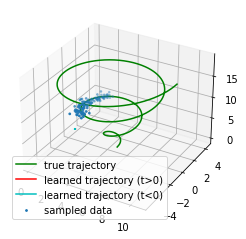

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 150/5000 tr_elbo:   -4.37
Iter:0  lhood:  237.42  kl_z:55.20     kl_w:   15.14
Epoch: 151/5000 tr_elbo:  -89.96
Iter:0  lhood:  254.68  kl_z:211.57    kl_w:   15.14
Epoch: 152/5000 tr_elbo:  243.09
Iter:0  lhood:  151.61  kl_z:164.27    kl_w:   15.14
Epoch: 153/5000 tr_elbo:  174.91
Iter:0  lhood:  272.78  kl_z:226.07    kl_w:   15.14
Epoch: 154/5000 tr_elbo:  201.74
Iter:0  lhood:  274.36  kl_z:97.35     kl_w:   15.14
Epoch: 155/5000 tr_elbo:  -78.57
Iter:0  lhood:  198.50  kl_z:56.81     kl_w:   15.14
Epoch: 156/5000 tr_elbo: -103.44
Iter:0  lhood:  273.65  kl_z:145.06    kl_w:   15.14
Epoch: 157/5000 tr_elbo:   76.81
Iter:0  lhood:  268.02  kl_z:184.38    kl_w:   15.14
Epoch: 158/5000 tr_elbo:  179.72
Iter:0  lhood:  290.60  kl_z:104.48    kl_w:   15.14
Epoch: 159/5000 tr_elbo:  -96.53
Iter:0  lhood:  280.75  kl_z:169.06    kl_w:   15.14


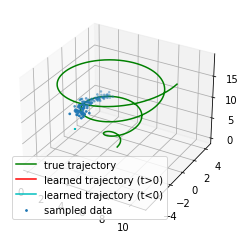

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 160/5000 tr_elbo:   80.05
Iter:0  lhood:  315.76  kl_z:234.69    kl_w:   15.14
Epoch: 161/5000 tr_elbo:  178.36
Iter:0  lhood:  250.00  kl_z:220.60    kl_w:   15.14
Epoch: 162/5000 tr_elbo:  314.54
Iter:0  lhood:  230.96  kl_z:86.86     kl_w:   15.14
Epoch: 163/5000 tr_elbo:  -81.75
Iter:0  lhood:  244.89  kl_z:55.26     kl_w:   15.14
Epoch: 164/5000 tr_elbo: -123.60
Iter:0  lhood:  315.55  kl_z:105.17    kl_w:   15.14
Epoch: 165/5000 tr_elbo:  -70.39
Iter:0  lhood:  253.45  kl_z:0.35      kl_w:   15.14
Epoch: 166/5000 tr_elbo: -238.61
Iter:0  lhood:  332.26  kl_z:182.81    kl_w:   15.14
Epoch: 167/5000 tr_elbo:   48.21
Iter:0  lhood:  327.22  kl_z:178.70    kl_w:   15.14
Epoch: 168/5000 tr_elbo:  101.52
Iter:0  lhood:  257.22  kl_z:64.54     kl_w:   15.14
Epoch: 169/5000 tr_elbo: -100.81
Iter:0  lhood:  262.76  kl_z:39.84     kl_w:   15.14


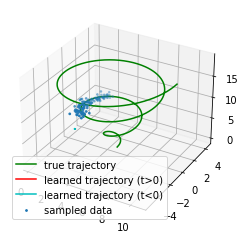

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 170/5000 tr_elbo: -146.51
Iter:0  lhood:  261.14  kl_z:65.14     kl_w:   15.14
Epoch: 171/5000 tr_elbo:  -96.69
Iter:0  lhood:  297.20  kl_z:149.44    kl_w:   15.14
Epoch: 172/5000 tr_elbo:  114.62
Iter:0  lhood:  313.83  kl_z:31.78     kl_w:   15.14
Epoch: 173/5000 tr_elbo: -252.45
Iter:0  lhood:  293.84  kl_z:92.26     kl_w:   15.14
Epoch: 174/5000 tr_elbo:  -71.71
Iter:0  lhood:  316.22  kl_z:69.42     kl_w:   15.14
Epoch: 175/5000 tr_elbo: -152.16
Iter:0  lhood:  340.60  kl_z:74.62     kl_w:   15.14
Epoch: 176/5000 tr_elbo: -142.24
Iter:0  lhood:  260.35  kl_z:125.81    kl_w:   15.14
Epoch: 177/5000 tr_elbo:   30.29
Iter:0  lhood:  262.27  kl_z:32.86     kl_w:   15.14
Epoch: 178/5000 tr_elbo: -157.65
Iter:0  lhood:  422.35  kl_z:195.42    kl_w:   15.14
Epoch: 179/5000 tr_elbo:  -33.97
Iter:0  lhood:  318.44  kl_z:55.58     kl_w:   15.14


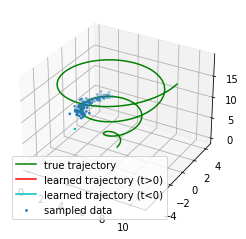

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 180/5000 tr_elbo: -200.20
Iter:0  lhood:  393.05  kl_z:58.97     kl_w:   15.14
Epoch: 181/5000 tr_elbo: -290.91
Iter:0  lhood:  399.95  kl_z:63.05     kl_w:   15.14
Epoch: 182/5000 tr_elbo: -259.21
Iter:0  lhood:  370.81  kl_z:74.43     kl_w:   15.14
Epoch: 183/5000 tr_elbo: -222.72
Iter:0  lhood:  287.12  kl_z:23.21     kl_w:   15.14
Epoch: 184/5000 tr_elbo: -229.81
Iter:0  lhood:  281.19  kl_z:36.53     kl_w:   15.14
Epoch: 185/5000 tr_elbo: -189.21
Iter:0  lhood:  417.82  kl_z:59.35     kl_w:   15.14
Epoch: 186/5000 tr_elbo: -334.90
Iter:0  lhood:  304.97  kl_z:32.98     kl_w:   15.14
Epoch: 187/5000 tr_elbo: -210.52
Iter:0  lhood:  359.53  kl_z:189.84    kl_w:   15.14
Epoch: 188/5000 tr_elbo:    6.30
Iter:0  lhood:  488.40  kl_z:83.72     kl_w:   15.14
Epoch: 189/5000 tr_elbo: -309.15
Iter:0  lhood:  424.25  kl_z:88.27     kl_w:   15.14


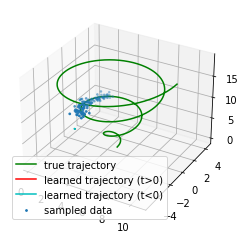

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 190/5000 tr_elbo: -254.63
Iter:0  lhood:  311.35  kl_z:73.47     kl_w:   15.14
Epoch: 191/5000 tr_elbo:  -99.92
Iter:0  lhood:  409.54  kl_z:27.31     kl_w:   15.14
Epoch: 192/5000 tr_elbo: -289.37
Iter:0  lhood:  502.82  kl_z:115.23    kl_w:   15.14
Epoch: 193/5000 tr_elbo: -271.33
Iter:0  lhood:  420.91  kl_z:22.24     kl_w:   15.14
Epoch: 194/5000 tr_elbo: -425.59
Iter:0  lhood:  453.51  kl_z:94.33     kl_w:   15.14
Epoch: 195/5000 tr_elbo: -182.19
Iter:0  lhood:  519.92  kl_z:107.95    kl_w:   15.14
Epoch: 196/5000 tr_elbo: -297.75
Iter:0  lhood:  562.58  kl_z:95.49     kl_w:   15.14
Epoch: 197/5000 tr_elbo: -374.22
Iter:0  lhood:  419.40  kl_z:24.50     kl_w:   15.14
Epoch: 198/5000 tr_elbo: -389.19
Iter:0  lhood:  501.61  kl_z:45.09     kl_w:   15.14
Epoch: 199/5000 tr_elbo: -420.29
Iter:0  lhood:  506.17  kl_z:119.88    kl_w:   15.14


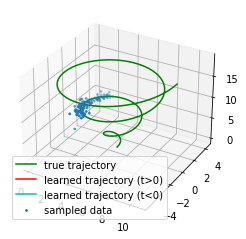

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 200/5000 tr_elbo: -170.03
Iter:0  lhood:  511.87  kl_z:50.99     kl_w:   15.14
Epoch: 201/5000 tr_elbo: -415.08
Iter:0  lhood:  518.51  kl_z:164.69    kl_w:   15.14
Epoch: 202/5000 tr_elbo: -253.21
Iter:0  lhood:  448.10  kl_z:68.73     kl_w:   15.14
Epoch: 203/5000 tr_elbo: -347.31
Iter:0  lhood:  546.89  kl_z:79.91     kl_w:   15.14
Epoch: 204/5000 tr_elbo: -413.32
Iter:0  lhood:  498.28  kl_z:23.26     kl_w:   15.14
Epoch: 205/5000 tr_elbo: -465.19
Iter:0  lhood:  617.38  kl_z:102.70    kl_w:   15.14
Epoch: 206/5000 tr_elbo: -441.57
Iter:0  lhood:  467.03  kl_z:19.45     kl_w:   15.14
Epoch: 207/5000 tr_elbo: -439.05
Iter:0  lhood:  533.69  kl_z:18.67     kl_w:   15.14
Epoch: 208/5000 tr_elbo: -497.75
Iter:0  lhood:  585.17  kl_z:62.23     kl_w:   15.14
Epoch: 209/5000 tr_elbo: -429.59
Iter:0  lhood:  599.99  kl_z:60.43     kl_w:   15.14


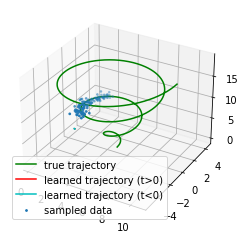

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 210/5000 tr_elbo: -522.22
Iter:0  lhood:  568.02  kl_z:38.65     kl_w:   15.14
Epoch: 211/5000 tr_elbo: -473.64
Iter:0  lhood:  482.47  kl_z:39.54     kl_w:   15.14
Epoch: 212/5000 tr_elbo: -359.04
Iter:0  lhood:  708.22  kl_z:192.39    kl_w:   15.14
Epoch: 213/5000 tr_elbo: -298.59
Iter:0  lhood:  448.49  kl_z:39.23     kl_w:   15.14
Epoch: 214/5000 tr_elbo: -229.34
Iter:0  lhood:  606.27  kl_z:38.09     kl_w:   15.14
Epoch: 215/5000 tr_elbo: -529.30
Iter:0  lhood:  626.68  kl_z:81.96     kl_w:   15.14
Epoch: 216/5000 tr_elbo: -505.81
Iter:0  lhood:  600.83  kl_z:56.48     kl_w:   15.14
Epoch: 217/5000 tr_elbo: -490.81
Iter:0  lhood:  614.44  kl_z:87.80     kl_w:   15.14
Epoch: 218/5000 tr_elbo: -457.90
Iter:0  lhood:  722.22  kl_z:121.09    kl_w:   15.14
Epoch: 219/5000 tr_elbo: -471.68
Iter:0  lhood:  603.77  kl_z:81.08     kl_w:   15.14


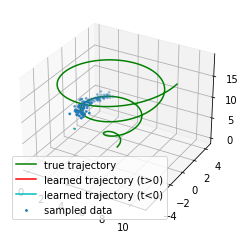

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 220/5000 tr_elbo: -503.20
Iter:0  lhood:  710.62  kl_z:111.10    kl_w:   15.14
Epoch: 221/5000 tr_elbo: -468.15
Iter:0  lhood:  727.79  kl_z:132.61    kl_w:   15.14
Epoch: 222/5000 tr_elbo: -460.68
Iter:0  lhood:  605.92  kl_z:79.32     kl_w:   15.14
Epoch: 223/5000 tr_elbo: -469.49
Iter:0  lhood:  720.08  kl_z:78.32     kl_w:   15.14
Epoch: 224/5000 tr_elbo: -638.33
Iter:0  lhood:  743.98  kl_z:140.15    kl_w:   15.14
Epoch: 225/5000 tr_elbo: -462.10
Iter:0  lhood:  648.47  kl_z:34.85     kl_w:   15.14
Epoch: 226/5000 tr_elbo: -613.32
Iter:0  lhood:  788.69  kl_z:133.96    kl_w:   15.14
Epoch: 227/5000 tr_elbo: -525.30
Iter:0  lhood:  788.76  kl_z:138.15    kl_w:   15.14
Epoch: 228/5000 tr_elbo: -579.78
Iter:0  lhood:  800.84  kl_z:52.78     kl_w:   15.14
Epoch: 229/5000 tr_elbo: -743.67
Iter:0  lhood:  733.79  kl_z:7.36      kl_w:   15.14


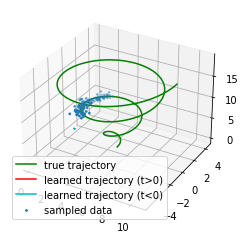

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 230/5000 tr_elbo: -775.63
Iter:0  lhood:  768.77  kl_z:43.67     kl_w:   15.14
Epoch: 231/5000 tr_elbo: -729.26
Iter:0  lhood:  752.92  kl_z:49.56     kl_w:   15.14
Epoch: 232/5000 tr_elbo: -613.62
Iter:0  lhood:  676.45  kl_z:37.30     kl_w:   15.14
Epoch: 233/5000 tr_elbo: -622.90
Iter:0  lhood:  844.51  kl_z:85.09     kl_w:   15.14
Epoch: 234/5000 tr_elbo: -734.10
Iter:0  lhood:  857.65  kl_z:97.01     kl_w:   15.14
Epoch: 235/5000 tr_elbo: -729.71
Iter:0  lhood:  782.97  kl_z:91.07     kl_w:   15.14
Epoch: 236/5000 tr_elbo: -662.60
Iter:0  lhood:  774.79  kl_z:51.23     kl_w:   15.14
Epoch: 237/5000 tr_elbo: -684.06
Iter:0  lhood:  829.29  kl_z:92.58     kl_w:   15.14
Epoch: 238/5000 tr_elbo: -743.43
Iter:0  lhood:  816.13  kl_z:64.79     kl_w:   15.14
Epoch: 239/5000 tr_elbo: -736.81
Iter:0  lhood:  915.11  kl_z:61.47     kl_w:   15.14


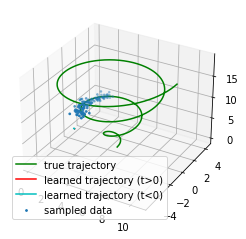

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 240/5000 tr_elbo: -827.14
Iter:0  lhood:  817.79  kl_z:90.41     kl_w:   15.14
Epoch: 241/5000 tr_elbo: -550.12
Iter:0  lhood:  845.89  kl_z:57.88     kl_w:   15.14
Epoch: 242/5000 tr_elbo: -776.17
Iter:0  lhood:  861.81  kl_z:73.73     kl_w:   15.14
Epoch: 243/5000 tr_elbo: -746.26
Iter:0  lhood:  759.57  kl_z:44.27     kl_w:   15.14
Epoch: 244/5000 tr_elbo: -704.62
Iter:0  lhood:  889.54  kl_z:127.53    kl_w:   15.14
Epoch: 245/5000 tr_elbo: -739.53
Iter:0  lhood:  602.41  kl_z:-9.30     kl_w:   15.14
Epoch: 246/5000 tr_elbo: -490.94
Iter:0  lhood:  796.53  kl_z:88.20     kl_w:   15.14
Epoch: 247/5000 tr_elbo: -683.79
Iter:0  lhood:  905.00  kl_z:82.07     kl_w:   15.14
Epoch: 248/5000 tr_elbo: -780.46
Iter:0  lhood:  958.97  kl_z:139.96    kl_w:   15.14
Epoch: 249/5000 tr_elbo: -766.62
Iter:0  lhood: 1016.56  kl_z:95.03     kl_w:   15.14


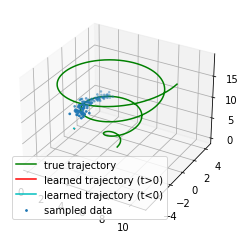

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 250/5000 tr_elbo: -858.83
Iter:0  lhood:  850.40  kl_z:77.94     kl_w:   15.14
Epoch: 251/5000 tr_elbo: -731.44
Iter:0  lhood:  934.30  kl_z:58.80     kl_w:   15.14
Epoch: 252/5000 tr_elbo: -910.45
Iter:0  lhood:  968.87  kl_z:25.28     kl_w:   15.14
Epoch: 253/5000 tr_elbo: -972.47
Iter:0  lhood:  862.73  kl_z:22.72     kl_w:   15.14
Epoch: 254/5000 tr_elbo: -804.50
Iter:0  lhood: 1036.38  kl_z:191.64    kl_w:   15.14
Epoch: 255/5000 tr_elbo: -694.31
Iter:0  lhood: 1085.90  kl_z:249.62    kl_w:   15.14
Epoch: 256/5000 tr_elbo: -594.15
Iter:0  lhood:  752.59  kl_z:-20.18    kl_w:   15.14
Epoch: 257/5000 tr_elbo: -783.79
Iter:0  lhood:  835.32  kl_z:17.65     kl_w:   15.14
Epoch: 258/5000 tr_elbo: -818.28
Iter:0  lhood:  906.75  kl_z:-5.21     kl_w:   15.14
Epoch: 259/5000 tr_elbo: -925.80
Iter:0  lhood:  887.38  kl_z:45.39     kl_w:   15.14


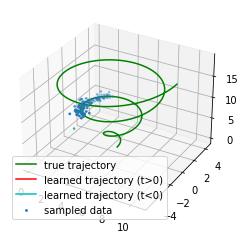

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 260/5000 tr_elbo: -813.12
Iter:0  lhood: 1068.54  kl_z:34.91     kl_w:   15.14
Epoch: 261/5000 tr_elbo:-1015.88
Iter:0  lhood:  906.09  kl_z:54.31     kl_w:   15.14
Epoch: 262/5000 tr_elbo: -851.57
Iter:0  lhood: 1168.98  kl_z:99.10     kl_w:   15.14
Epoch: 263/5000 tr_elbo:-1026.98
Iter:0  lhood: 1183.12  kl_z:171.67    kl_w:   15.14
Epoch: 264/5000 tr_elbo: -950.48
Iter:0  lhood:  815.49  kl_z:26.59     kl_w:   15.14
Epoch: 265/5000 tr_elbo: -731.35
Iter:0  lhood: 1040.54  kl_z:46.84     kl_w:   15.14
Epoch: 266/5000 tr_elbo: -958.66
Iter:0  lhood: 1091.92  kl_z:70.40     kl_w:   15.14
Epoch: 267/5000 tr_elbo:-1072.66
Iter:0  lhood: 1169.12  kl_z:98.48     kl_w:   15.14
Epoch: 268/5000 tr_elbo:-1096.47
Iter:0  lhood: 1161.25  kl_z:103.53    kl_w:   15.14
Epoch: 269/5000 tr_elbo: -983.68
Iter:0  lhood: 1033.06  kl_z:24.26     kl_w:   15.14


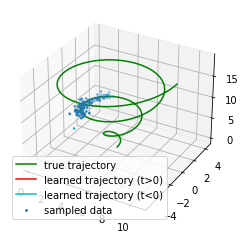

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 270/5000 tr_elbo:-1018.12
Iter:0  lhood: 1021.67  kl_z:30.61     kl_w:   15.14
Epoch: 271/5000 tr_elbo: -982.99
Iter:0  lhood: 1207.18  kl_z:132.41    kl_w:   15.14
Epoch: 272/5000 tr_elbo:-1060.12
Iter:0  lhood: 1152.47  kl_z:30.63     kl_w:   15.14
Epoch: 273/5000 tr_elbo:-1165.48
Iter:0  lhood: 1140.11  kl_z:-24.39    kl_w:   15.14
Epoch: 274/5000 tr_elbo:-1193.85
Iter:0  lhood: 1216.08  kl_z:112.10    kl_w:   15.14
Epoch: 275/5000 tr_elbo:-1033.56
Iter:0  lhood: 1168.83  kl_z:15.23     kl_w:   15.14
Epoch: 276/5000 tr_elbo:-1238.79
Iter:0  lhood: 1195.08  kl_z:25.39     kl_w:   15.14
Epoch: 277/5000 tr_elbo:-1141.11
Iter:0  lhood: 1270.44  kl_z:140.13    kl_w:   15.14
Epoch: 278/5000 tr_elbo: -906.51
Iter:0  lhood: 1177.88  kl_z:18.65     kl_w:   15.14
Epoch: 279/5000 tr_elbo:-1182.07
Iter:0  lhood: 1284.33  kl_z:67.80     kl_w:   15.14


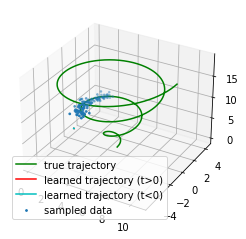

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 280/5000 tr_elbo:-1214.87
Iter:0  lhood: 1379.41  kl_z:186.18    kl_w:   15.15
Epoch: 281/5000 tr_elbo:-1118.93
Iter:0  lhood: 1165.37  kl_z:36.33     kl_w:   15.15
Epoch: 282/5000 tr_elbo:-1156.34
Iter:0  lhood: 1271.42  kl_z:35.46     kl_w:   15.15
Epoch: 283/5000 tr_elbo:-1292.83
Iter:0  lhood: 1236.19  kl_z:34.17     kl_w:   15.15
Epoch: 284/5000 tr_elbo:-1218.04
Iter:0  lhood: 1318.53  kl_z:64.81     kl_w:   15.15
Epoch: 285/5000 tr_elbo:-1260.08
Iter:0  lhood: 1071.37  kl_z:-8.33     kl_w:   15.15
Epoch: 286/5000 tr_elbo:-1073.98
Iter:0  lhood: 1343.81  kl_z:5.98      kl_w:   15.15
Epoch: 287/5000 tr_elbo:-1420.73
Iter:0  lhood: 1196.96  kl_z:33.39     kl_w:   15.15
Epoch: 288/5000 tr_elbo:-1160.28
Iter:0  lhood: 1430.88  kl_z:38.42     kl_w:   15.15
Epoch: 289/5000 tr_elbo:-1432.90
Iter:0  lhood: 1205.32  kl_z:-16.65    kl_w:   15.15


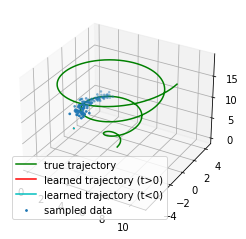

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 290/5000 tr_elbo:-1318.06
Iter:0  lhood: 1240.04  kl_z:6.77      kl_w:   15.15
Epoch: 291/5000 tr_elbo:-1273.97
Iter:0  lhood: 1525.11  kl_z:261.08    kl_w:   15.15
Epoch: 292/5000 tr_elbo:-1101.80
Iter:0  lhood: 1173.70  kl_z:-8.91     kl_w:   15.15
Epoch: 293/5000 tr_elbo:-1143.74
Iter:0  lhood: 1333.86  kl_z:112.39    kl_w:   15.15
Epoch: 294/5000 tr_elbo:-1128.95
Iter:0  lhood: 1284.00  kl_z:71.78     kl_w:   15.15
Epoch: 295/5000 tr_elbo:-1198.19
Iter:0  lhood: 1671.86  kl_z:302.19    kl_w:   15.15
Epoch: 296/5000 tr_elbo:-1137.33
Iter:0  lhood: 1546.65  kl_z:165.58    kl_w:   15.15
Epoch: 297/5000 tr_elbo:-1359.09
Iter:0  lhood: 1307.51  kl_z:-0.94     kl_w:   15.15
Epoch: 298/5000 tr_elbo:-1403.68
Iter:0  lhood: 1414.14  kl_z:47.74     kl_w:   15.15
Epoch: 299/5000 tr_elbo:-1409.71
Iter:0  lhood: 1321.07  kl_z:35.04     kl_w:   15.15


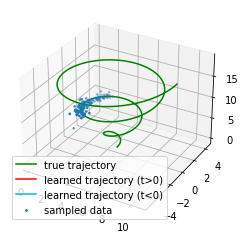

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 300/5000 tr_elbo:-1107.26
Iter:0  lhood: 1275.96  kl_z:3.38      kl_w:   15.15
Epoch: 301/5000 tr_elbo:-1264.70
Iter:0  lhood: 1389.80  kl_z:12.09     kl_w:   15.15
Epoch: 302/5000 tr_elbo:-1431.50
Iter:0  lhood: 1636.88  kl_z:102.82    kl_w:   15.15
Epoch: 303/5000 tr_elbo:-1509.54
Iter:0  lhood: 1538.19  kl_z:73.93     kl_w:   15.15
Epoch: 304/5000 tr_elbo:-1509.57
Iter:0  lhood: 1609.12  kl_z:132.23    kl_w:   15.15
Epoch: 305/5000 tr_elbo:-1520.10
Iter:0  lhood: 1307.89  kl_z:10.25     kl_w:   15.15
Epoch: 306/5000 tr_elbo:-1294.97
Iter:0  lhood: 1317.48  kl_z:-10.12    kl_w:   15.15
Epoch: 307/5000 tr_elbo:-1372.64
Iter:0  lhood: 1384.42  kl_z:49.73     kl_w:   15.15
Epoch: 308/5000 tr_elbo:-1372.39
Iter:0  lhood: 1603.39  kl_z:36.09     kl_w:   15.15
Epoch: 309/5000 tr_elbo:-1551.22
Iter:0  lhood: 1628.05  kl_z:66.72     kl_w:   15.15


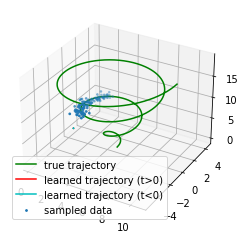

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 310/5000 tr_elbo:-1575.02
Iter:0  lhood: 1641.57  kl_z:73.99     kl_w:   15.15
Epoch: 311/5000 tr_elbo:-1571.70
Iter:0  lhood: 1559.30  kl_z:105.34    kl_w:   15.15
Epoch: 312/5000 tr_elbo:-1476.78
Iter:0  lhood: 1471.51  kl_z:4.37      kl_w:   15.15
Epoch: 313/5000 tr_elbo:-1497.07
Iter:0  lhood: 1656.47  kl_z:138.05    kl_w:   15.15
Epoch: 314/5000 tr_elbo:-1438.93
Iter:0  lhood: 1716.67  kl_z:44.19     kl_w:   15.15
Epoch: 315/5000 tr_elbo:-1713.27
Iter:0  lhood: 1761.46  kl_z:137.67    kl_w:   15.15
Epoch: 316/5000 tr_elbo:-1593.72
Iter:0  lhood: 1661.87  kl_z:42.93     kl_w:   15.15
Epoch: 317/5000 tr_elbo:-1668.23
Iter:0  lhood: 1724.83  kl_z:154.29    kl_w:   15.15
Epoch: 318/5000 tr_elbo:-1505.77
Iter:0  lhood: 1947.61  kl_z:318.69    kl_w:   15.15
Epoch: 319/5000 tr_elbo:-1411.36
Iter:0  lhood: 1854.00  kl_z:228.64    kl_w:   15.15


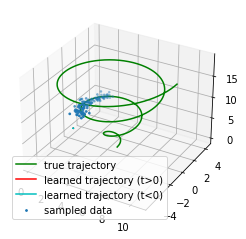

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 320/5000 tr_elbo:-1555.93
Iter:0  lhood: 1750.77  kl_z:38.91     kl_w:   15.15
Epoch: 321/5000 tr_elbo:-1723.89
Iter:0  lhood: 1767.84  kl_z:123.37    kl_w:   15.15
Epoch: 322/5000 tr_elbo:-1740.23
Iter:0  lhood: 1593.24  kl_z:30.10     kl_w:   15.15
Epoch: 323/5000 tr_elbo:-1650.20
Iter:0  lhood: 1508.88  kl_z:-10.40    kl_w:   15.15
Epoch: 324/5000 tr_elbo:-1431.73
Iter:0  lhood: 1723.02  kl_z:64.06     kl_w:   15.15
Epoch: 325/5000 tr_elbo:-1722.60
Iter:0  lhood: 2086.31  kl_z:484.50    kl_w:   15.15
Epoch: 326/5000 tr_elbo:-1181.43
Iter:0  lhood: 1938.85  kl_z:141.02    kl_w:   15.15
Epoch: 327/5000 tr_elbo:-1828.95
Iter:0  lhood: 1815.71  kl_z:98.07     kl_w:   15.15
Epoch: 328/5000 tr_elbo:-1656.74
Iter:0  lhood: 1711.61  kl_z:17.85     kl_w:   15.15
Epoch: 329/5000 tr_elbo:-1770.12
Iter:0  lhood: 1764.88  kl_z:91.50     kl_w:   15.15


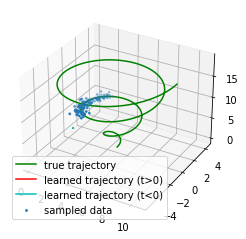

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 330/5000 tr_elbo:-1715.96
Iter:0  lhood: 1648.54  kl_z:-34.18    kl_w:   15.15
Epoch: 331/5000 tr_elbo:-1749.66
Iter:0  lhood: 1955.39  kl_z:155.56    kl_w:   15.15
Epoch: 332/5000 tr_elbo:-1807.13
Iter:0  lhood: 1471.80  kl_z:-36.13    kl_w:   15.15
Epoch: 333/5000 tr_elbo:-1463.52
Iter:0  lhood: 1817.48  kl_z:59.84     kl_w:   15.15
Epoch: 334/5000 tr_elbo:-1850.01
Iter:0  lhood: 1879.47  kl_z:96.67     kl_w:   15.15
Epoch: 335/5000 tr_elbo:-1865.54
Iter:0  lhood: 1884.78  kl_z:5.48      kl_w:   15.15
Epoch: 336/5000 tr_elbo:-2021.55
Iter:0  lhood: 1865.57  kl_z:45.39     kl_w:   15.15
Epoch: 337/5000 tr_elbo:-1935.25
Iter:0  lhood: 1768.38  kl_z:60.89     kl_w:   15.15
Epoch: 338/5000 tr_elbo:-1779.85
Iter:0  lhood: 2103.29  kl_z:243.38    kl_w:   15.15
Epoch: 339/5000 tr_elbo:-1853.04
Iter:0  lhood: 2185.89  kl_z:359.05    kl_w:   15.15


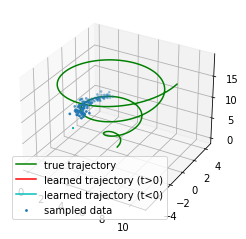

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 340/5000 tr_elbo:-1668.13
Iter:0  lhood: 1835.74  kl_z:31.22     kl_w:   15.15
Epoch: 341/5000 tr_elbo:-1825.60
Iter:0  lhood: 2018.56  kl_z:63.58     kl_w:   15.15
Epoch: 342/5000 tr_elbo:-2024.79
Iter:0  lhood: 2062.08  kl_z:109.20    kl_w:   15.15
Epoch: 343/5000 tr_elbo:-1979.88
Iter:0  lhood: 1905.88  kl_z:65.65     kl_w:   15.15
Epoch: 344/5000 tr_elbo:-1827.70
Iter:0  lhood: 2277.88  kl_z:307.29    kl_w:   15.15
Epoch: 345/5000 tr_elbo:-1633.39
Iter:0  lhood: 2167.15  kl_z:143.22    kl_w:   15.15
Epoch: 346/5000 tr_elbo:-2073.42
Iter:0  lhood: 2120.62  kl_z:143.50    kl_w:   15.15
Epoch: 347/5000 tr_elbo:-2030.15
Iter:0  lhood: 1932.88  kl_z:71.57     kl_w:   15.15
Epoch: 348/5000 tr_elbo:-1914.00
Iter:0  lhood: 1975.07  kl_z:42.16     kl_w:   15.15
Epoch: 349/5000 tr_elbo:-2014.26
Iter:0  lhood: 2013.12  kl_z:38.33     kl_w:   15.15


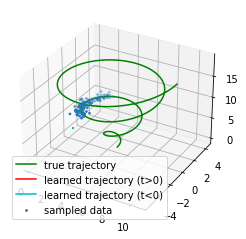

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 350/5000 tr_elbo:-2067.92
Iter:0  lhood: 2136.96  kl_z:80.02     kl_w:   15.15
Epoch: 351/5000 tr_elbo:-2131.78
Iter:0  lhood: 1880.80  kl_z:29.43     kl_w:   15.15
Epoch: 352/5000 tr_elbo:-1964.17
Iter:0  lhood: 2068.89  kl_z:82.50     kl_w:   15.15
Epoch: 353/5000 tr_elbo:-2006.48
Iter:0  lhood: 2006.93  kl_z:26.35     kl_w:   15.15
Epoch: 354/5000 tr_elbo:-2019.91
Iter:0  lhood: 2040.55  kl_z:43.92     kl_w:   15.15
Epoch: 355/5000 tr_elbo:-2016.00
Iter:0  lhood: 2150.76  kl_z:83.52     kl_w:   15.15
Epoch: 356/5000 tr_elbo:-2144.18
Iter:0  lhood: 2010.18  kl_z:24.78     kl_w:   15.15
Epoch: 357/5000 tr_elbo:-2089.81
Iter:0  lhood: 2289.90  kl_z:177.69    kl_w:   15.15
Epoch: 358/5000 tr_elbo:-2104.09
Iter:0  lhood: 2138.44  kl_z:92.77     kl_w:   15.15
Epoch: 359/5000 tr_elbo:-2053.40
Iter:0  lhood: 2136.93  kl_z:86.35     kl_w:   15.15


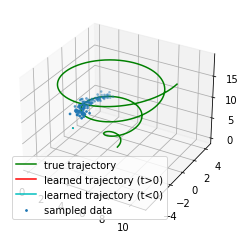

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 360/5000 tr_elbo:-1946.25
Iter:0  lhood: 2052.52  kl_z:13.74     kl_w:   15.15
Epoch: 361/5000 tr_elbo:-2032.55
Iter:0  lhood: 2149.77  kl_z:98.01     kl_w:   15.15
Epoch: 362/5000 tr_elbo:-2023.65
Iter:0  lhood: 2014.98  kl_z:72.97     kl_w:   15.15
Epoch: 363/5000 tr_elbo:-1895.93
Iter:0  lhood: 2274.79  kl_z:140.07    kl_w:   15.15
Epoch: 364/5000 tr_elbo:-2148.30
Iter:0  lhood: 2377.74  kl_z:231.99    kl_w:   15.15
Epoch: 365/5000 tr_elbo:-2205.87
Iter:0  lhood: 2226.35  kl_z:98.58     kl_w:   15.15
Epoch: 366/5000 tr_elbo:-2236.22
Iter:0  lhood: 2442.91  kl_z:192.43    kl_w:   15.15
Epoch: 367/5000 tr_elbo:-2192.93
Iter:0  lhood: 2418.83  kl_z:218.43    kl_w:   15.15
Epoch: 368/5000 tr_elbo:-2158.35
Iter:0  lhood: 2442.66  kl_z:306.49    kl_w:   15.15
Epoch: 369/5000 tr_elbo:-1786.69
Iter:0  lhood: 2302.58  kl_z:44.74     kl_w:   15.15


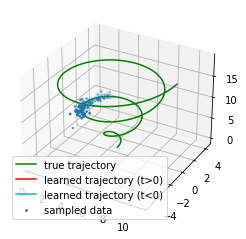

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 370/5000 tr_elbo:-2261.45
Iter:0  lhood: 2144.80  kl_z:7.61      kl_w:   15.15
Epoch: 371/5000 tr_elbo:-2147.45
Iter:0  lhood: 2402.02  kl_z:209.06    kl_w:   15.15
Epoch: 372/5000 tr_elbo:-2267.36
Iter:0  lhood: 2499.42  kl_z:207.85    kl_w:   15.15
Epoch: 373/5000 tr_elbo:-2247.56
Iter:0  lhood: 2200.66  kl_z:23.24     kl_w:   15.15
Epoch: 374/5000 tr_elbo:-2179.79
Iter:0  lhood: 2504.63  kl_z:167.98    kl_w:   15.15
Epoch: 375/5000 tr_elbo:-2310.95
Iter:0  lhood: 2297.07  kl_z:53.78     kl_w:   15.15
Epoch: 376/5000 tr_elbo:-2262.44
Iter:0  lhood: 2345.39  kl_z:62.28     kl_w:   15.15
Epoch: 377/5000 tr_elbo:-2344.49
Iter:0  lhood: 2293.70  kl_z:63.97     kl_w:   15.15
Epoch: 378/5000 tr_elbo:-2340.23
Iter:0  lhood: 2512.72  kl_z:160.31    kl_w:   15.15
Epoch: 379/5000 tr_elbo:-2484.98
Iter:0  lhood: 2446.37  kl_z:91.84     kl_w:   15.15


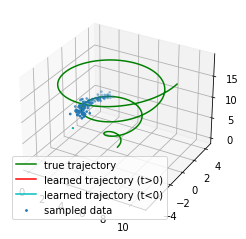

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 380/5000 tr_elbo:-2471.46
Iter:0  lhood: 2438.37  kl_z:162.55    kl_w:   15.15
Epoch: 381/5000 tr_elbo:-2331.50
Iter:0  lhood: 2506.34  kl_z:154.78    kl_w:   15.15
Epoch: 382/5000 tr_elbo:-2442.43
Iter:0  lhood: 2519.89  kl_z:70.03     kl_w:   15.15
Epoch: 383/5000 tr_elbo:-2573.74
Iter:0  lhood: 2478.97  kl_z:98.17     kl_w:   15.15
Epoch: 384/5000 tr_elbo:-2511.79
Iter:0  lhood: 2490.83  kl_z:73.15     kl_w:   15.15
Epoch: 385/5000 tr_elbo:-2532.29
Iter:0  lhood: 2438.94  kl_z:126.67    kl_w:   15.15
Epoch: 386/5000 tr_elbo:-2462.32
Iter:0  lhood: 2603.23  kl_z:131.35    kl_w:   15.15
Epoch: 387/5000 tr_elbo:-2510.46
Iter:0  lhood: 2254.68  kl_z:33.07     kl_w:   15.15
Epoch: 388/5000 tr_elbo:-2180.96
Iter:0  lhood: 2421.96  kl_z:27.65     kl_w:   15.15
Epoch: 389/5000 tr_elbo:-2510.39
Iter:0  lhood: 2602.21  kl_z:151.65    kl_w:   15.15


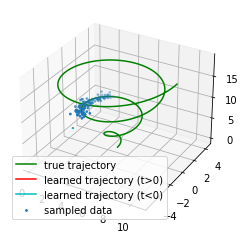

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 390/5000 tr_elbo:-2358.76
Iter:0  lhood: 2608.87  kl_z:136.65    kl_w:   15.15
Epoch: 391/5000 tr_elbo:-2465.14
Iter:0  lhood: 2656.19  kl_z:155.73    kl_w:   15.15
Epoch: 392/5000 tr_elbo:-2489.21
Iter:0  lhood: 2513.74  kl_z:128.36    kl_w:   15.15
Epoch: 393/5000 tr_elbo:-2536.31
Iter:0  lhood: 2718.99  kl_z:178.37    kl_w:   15.15
Epoch: 394/5000 tr_elbo:-2583.10
Iter:0  lhood: 2521.02  kl_z:7.30      kl_w:   15.15
Epoch: 395/5000 tr_elbo:-2688.93
Iter:0  lhood: 2455.53  kl_z:29.09     kl_w:   15.15
Epoch: 396/5000 tr_elbo:-2504.08
Iter:0  lhood: 2615.14  kl_z:69.76     kl_w:   15.15
Epoch: 397/5000 tr_elbo:-2643.85
Iter:0  lhood: 2604.08  kl_z:15.30     kl_w:   15.15
Epoch: 398/5000 tr_elbo:-2676.92
Iter:0  lhood: 2647.42  kl_z:39.33     kl_w:   15.15
Epoch: 399/5000 tr_elbo:-2774.49
Iter:0  lhood: 2548.32  kl_z:78.58     kl_w:   15.15


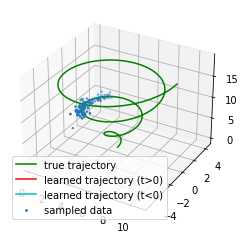

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 400/5000 tr_elbo:-2583.28
Iter:0  lhood: 2712.58  kl_z:171.06    kl_w:   15.15
Epoch: 401/5000 tr_elbo:-2449.06
Iter:0  lhood: 2970.40  kl_z:649.64    kl_w:   15.15
Epoch: 402/5000 tr_elbo:-1622.04
Iter:0  lhood: 2554.60  kl_z:-5.73     kl_w:   15.15
Epoch: 403/5000 tr_elbo:-2680.87
Iter:0  lhood: 2768.37  kl_z:126.08    kl_w:   15.15
Epoch: 404/5000 tr_elbo:-2815.36
Iter:0  lhood: 2697.57  kl_z:103.93    kl_w:   15.15
Epoch: 405/5000 tr_elbo:-2756.02
Iter:0  lhood: 2669.69  kl_z:182.65    kl_w:   15.15
Epoch: 406/5000 tr_elbo:-2374.16
Iter:0  lhood: 2691.65  kl_z:28.89     kl_w:   15.15
Epoch: 407/5000 tr_elbo:-2840.74
Iter:0  lhood: 2903.67  kl_z:273.16    kl_w:   15.15
Epoch: 408/5000 tr_elbo:-2673.47
Iter:0  lhood: 2816.62  kl_z:177.41    kl_w:   15.15
Epoch: 409/5000 tr_elbo:-2777.55
Iter:0  lhood: 2864.65  kl_z:212.41    kl_w:   15.15


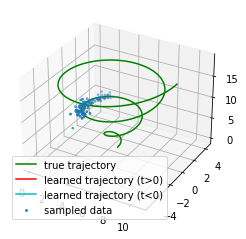

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 410/5000 tr_elbo:-2732.56
Iter:0  lhood: 2637.43  kl_z:34.21     kl_w:   15.15
Epoch: 411/5000 tr_elbo:-2527.60
Iter:0  lhood: 2721.43  kl_z:74.79     kl_w:   15.15
Epoch: 412/5000 tr_elbo:-2731.34
Iter:0  lhood: 2824.34  kl_z:193.30    kl_w:   15.15
Epoch: 413/5000 tr_elbo:-2603.85
Iter:0  lhood: 2802.51  kl_z:142.60    kl_w:   15.15
Epoch: 414/5000 tr_elbo:-2801.88
Iter:0  lhood: 2580.73  kl_z:22.11     kl_w:   15.15
Epoch: 415/5000 tr_elbo:-2485.15
Iter:0  lhood: 3008.72  kl_z:296.01    kl_w:   15.15
Epoch: 416/5000 tr_elbo:-2596.50
Iter:0  lhood: 2887.59  kl_z:331.62    kl_w:   15.15
Epoch: 417/5000 tr_elbo:-2418.53
Iter:0  lhood: 2726.67  kl_z:110.97    kl_w:   15.15
Epoch: 418/5000 tr_elbo:-2596.56
Iter:0  lhood: 2931.64  kl_z:141.97    kl_w:   15.15
Epoch: 419/5000 tr_elbo:-2917.40
Iter:0  lhood: 2787.10  kl_z:122.18    kl_w:   15.15


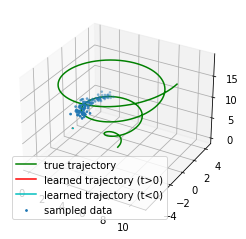

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 420/5000 tr_elbo:-2717.14
Iter:0  lhood: 2765.16  kl_z:26.25     kl_w:   15.15
Epoch: 421/5000 tr_elbo:-2900.48
Iter:0  lhood: 2878.99  kl_z:103.83    kl_w:   15.15
Epoch: 422/5000 tr_elbo:-2841.78
Iter:0  lhood: 2795.30  kl_z:69.42     kl_w:   15.15
Epoch: 423/5000 tr_elbo:-2701.92
Iter:0  lhood: 3129.02  kl_z:479.19    kl_w:   15.15
Epoch: 424/5000 tr_elbo:-2156.34
Iter:0  lhood: 2947.99  kl_z:216.17    kl_w:   15.15
Epoch: 425/5000 tr_elbo:-2539.06
Iter:0  lhood: 3022.82  kl_z:168.84    kl_w:   15.15
Epoch: 426/5000 tr_elbo:-2899.67
Iter:0  lhood: 2977.73  kl_z:91.37     kl_w:   15.15
Epoch: 427/5000 tr_elbo:-3074.39
Iter:0  lhood: 2787.12  kl_z:2.07      kl_w:   15.15
Epoch: 428/5000 tr_elbo:-2800.22
Iter:0  lhood: 3031.24  kl_z:211.03    kl_w:   15.15
Epoch: 429/5000 tr_elbo:-2796.91
Iter:0  lhood: 2939.83  kl_z:47.85     kl_w:   15.15


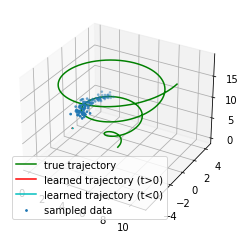

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 430/5000 tr_elbo:-3076.52
Iter:0  lhood: 2794.80  kl_z:64.54     kl_w:   15.15
Epoch: 431/5000 tr_elbo:-2778.12
Iter:0  lhood: 2931.88  kl_z:89.46     kl_w:   15.15
Epoch: 432/5000 tr_elbo:-2909.75
Iter:0  lhood: 2972.56  kl_z:89.51     kl_w:   15.15
Epoch: 433/5000 tr_elbo:-3100.65
Iter:0  lhood: 2881.44  kl_z:88.18     kl_w:   15.15
Epoch: 434/5000 tr_elbo:-2875.15
Iter:0  lhood: 3166.68  kl_z:348.84    kl_w:   15.15
Epoch: 435/5000 tr_elbo:-2682.15
Iter:0  lhood: 3118.32  kl_z:216.59    kl_w:   15.15
Epoch: 436/5000 tr_elbo:-2843.59
Iter:0  lhood: 3083.82  kl_z:151.41    kl_w:   15.15
Epoch: 437/5000 tr_elbo:-3101.83
Iter:0  lhood: 2947.50  kl_z:107.74    kl_w:   15.15
Epoch: 438/5000 tr_elbo:-2964.05
Iter:0  lhood: 3169.85  kl_z:308.12    kl_w:   15.15
Epoch: 439/5000 tr_elbo:-2848.04
Iter:0  lhood: 3132.79  kl_z:225.70    kl_w:   15.15


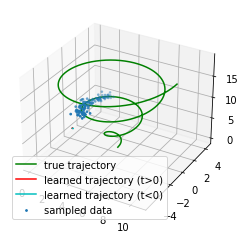

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 440/5000 tr_elbo:-2915.92
Iter:0  lhood: 3170.96  kl_z:249.07    kl_w:   15.15
Epoch: 441/5000 tr_elbo:-2896.72
Iter:0  lhood: 3206.08  kl_z:283.71    kl_w:   15.15
Epoch: 442/5000 tr_elbo:-2945.43
Iter:0  lhood: 3093.32  kl_z:134.48    kl_w:   15.15
Epoch: 443/5000 tr_elbo:-3095.95
Iter:0  lhood: 2924.89  kl_z:110.44    kl_w:   15.15
Epoch: 444/5000 tr_elbo:-2771.80
Iter:0  lhood: 2947.26  kl_z:15.60     kl_w:   15.15
Epoch: 445/5000 tr_elbo:-3069.31
Iter:0  lhood: 3022.93  kl_z:59.70     kl_w:   15.15
Epoch: 446/5000 tr_elbo:-3123.10
Iter:0  lhood: 3047.98  kl_z:59.57     kl_w:   15.15
Epoch: 447/5000 tr_elbo:-3009.95
Iter:0  lhood: 3161.07  kl_z:108.79    kl_w:   15.15
Epoch: 448/5000 tr_elbo:-3264.24
Iter:0  lhood: 3111.28  kl_z:137.39    kl_w:   15.15
Epoch: 449/5000 tr_elbo:-3146.31
Iter:0  lhood: 3216.50  kl_z:136.55    kl_w:   15.15


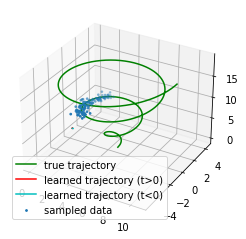

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 450/5000 tr_elbo:-3129.71
Iter:0  lhood: 3220.88  kl_z:204.36    kl_w:   15.15
Epoch: 451/5000 tr_elbo:-3123.95
Iter:0  lhood: 2991.85  kl_z:96.73     kl_w:   15.15
Epoch: 452/5000 tr_elbo:-2980.98
Iter:0  lhood: 3231.55  kl_z:208.96    kl_w:   15.15
Epoch: 453/5000 tr_elbo:-3097.14
Iter:0  lhood: 3003.02  kl_z:23.16     kl_w:   15.15
Epoch: 454/5000 tr_elbo:-3050.73
Iter:0  lhood: 2970.42  kl_z:34.12     kl_w:   15.15
Epoch: 455/5000 tr_elbo:-2829.48
Iter:0  lhood: 3237.01  kl_z:198.08    kl_w:   15.15
Epoch: 456/5000 tr_elbo:-3184.22
Iter:0  lhood: 2960.09  kl_z:-8.63     kl_w:   15.15
Epoch: 457/5000 tr_elbo:-2858.61
Iter:0  lhood: 3210.04  kl_z:86.87     kl_w:   15.15
Epoch: 458/5000 tr_elbo:-3302.37
Iter:0  lhood: 3305.39  kl_z:183.44    kl_w:   15.15
Epoch: 459/5000 tr_elbo:-3284.48
Iter:0  lhood: 3095.18  kl_z:40.81     kl_w:   15.15


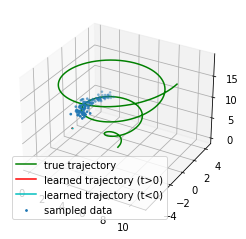

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 460/5000 tr_elbo:-3056.38
Iter:0  lhood: 3186.44  kl_z:75.48     kl_w:   15.15
Epoch: 461/5000 tr_elbo:-3301.60
Iter:0  lhood: 3145.40  kl_z:114.09    kl_w:   15.15
Epoch: 462/5000 tr_elbo:-3215.21
Iter:0  lhood: 3238.62  kl_z:150.85    kl_w:   15.15
Epoch: 463/5000 tr_elbo:-2922.97
Iter:0  lhood: 3269.31  kl_z:134.51    kl_w:   15.15
Epoch: 464/5000 tr_elbo:-3347.75
Iter:0  lhood: 3320.54  kl_z:202.50    kl_w:   15.15
Epoch: 465/5000 tr_elbo:-3249.98
Iter:0  lhood: 3321.71  kl_z:237.34    kl_w:   15.15
Epoch: 466/5000 tr_elbo:-3161.13
Iter:0  lhood: 3277.66  kl_z:164.11    kl_w:   15.15
Epoch: 467/5000 tr_elbo:-3233.97
Iter:0  lhood: 3153.84  kl_z:53.81     kl_w:   15.15
Epoch: 468/5000 tr_elbo:-3274.80
Iter:0  lhood: 3350.65  kl_z:169.17    kl_w:   15.15
Epoch: 469/5000 tr_elbo:-3282.90
Iter:0  lhood: 3220.09  kl_z:68.86     kl_w:   15.15


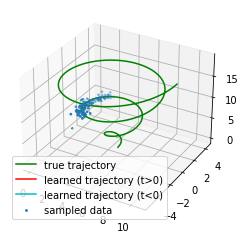

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 470/5000 tr_elbo:-3101.33
Iter:0  lhood: 3356.55  kl_z:120.47    kl_w:   15.15
Epoch: 471/5000 tr_elbo:-3439.24
Iter:0  lhood: 3431.91  kl_z:330.56    kl_w:   15.15
Epoch: 472/5000 tr_elbo:-3196.62
Iter:0  lhood: 3395.85  kl_z:147.51    kl_w:   15.15
Epoch: 473/5000 tr_elbo:-3408.69
Iter:0  lhood: 3261.86  kl_z:95.92     kl_w:   15.15
Epoch: 474/5000 tr_elbo:-3311.76
Iter:0  lhood: 3396.47  kl_z:220.36    kl_w:   15.15
Epoch: 475/5000 tr_elbo:-3326.54
Iter:0  lhood: 3158.31  kl_z:30.42     kl_w:   15.15
Epoch: 476/5000 tr_elbo:-3221.77
Iter:0  lhood: 3407.19  kl_z:233.99    kl_w:   15.15
Epoch: 477/5000 tr_elbo:-3297.95
Iter:0  lhood: 3452.90  kl_z:222.10    kl_w:   15.15
Epoch: 478/5000 tr_elbo:-3291.29
Iter:0  lhood: 3415.75  kl_z:185.98    kl_w:   15.15
Epoch: 479/5000 tr_elbo:-3446.99
Iter:0  lhood: 3369.98  kl_z:185.54    kl_w:   15.15


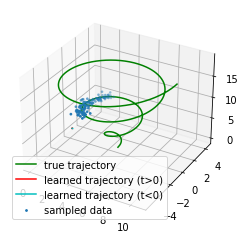

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 480/5000 tr_elbo:-2895.10
Iter:0  lhood: 3434.37  kl_z:250.74    kl_w:   15.15
Epoch: 481/5000 tr_elbo:-3138.22
Iter:0  lhood: 3455.59  kl_z:306.20    kl_w:   15.15
Epoch: 482/5000 tr_elbo:-2834.08
Iter:0  lhood: 3469.34  kl_z:146.34    kl_w:   15.15
Epoch: 483/5000 tr_elbo:-3470.34
Iter:0  lhood: 3318.12  kl_z:78.88     kl_w:   15.15
Epoch: 484/5000 tr_elbo:-3419.41
Iter:0  lhood: 3421.13  kl_z:212.00    kl_w:   15.15
Epoch: 485/5000 tr_elbo:-2717.79
Iter:0  lhood: 3159.00  kl_z:116.02    kl_w:   15.15
Epoch: 486/5000 tr_elbo:-3068.91
Iter:0  lhood: 3263.77  kl_z:38.99     kl_w:   15.15
Epoch: 487/5000 tr_elbo:-3297.77
Iter:0  lhood: 3348.54  kl_z:180.73    kl_w:   15.15
Epoch: 488/5000 tr_elbo:-3298.63
Iter:0  lhood: 3488.96  kl_z:159.95    kl_w:   15.15
Epoch: 489/5000 tr_elbo:-3439.66
Iter:0  lhood: 3470.47  kl_z:143.09    kl_w:   15.15


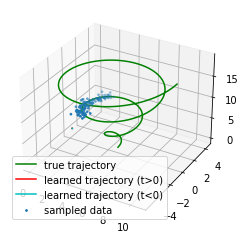

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 490/5000 tr_elbo:-3378.97
Iter:0  lhood: 3339.08  kl_z:78.87     kl_w:   15.15
Epoch: 491/5000 tr_elbo:-3452.69
Iter:0  lhood: 3504.22  kl_z:99.28     kl_w:   15.15
Epoch: 492/5000 tr_elbo:-3526.90
Iter:0  lhood: 3540.41  kl_z:172.94    kl_w:   15.15
Epoch: 493/5000 tr_elbo:-3515.05
Iter:0  lhood: 3512.30  kl_z:163.08    kl_w:   15.15
Epoch: 494/5000 tr_elbo:-3474.00
Iter:0  lhood: 3501.17  kl_z:150.69    kl_w:   15.15
Epoch: 495/5000 tr_elbo:-3480.36
Iter:0  lhood: 3557.85  kl_z:244.23    kl_w:   15.15
Epoch: 496/5000 tr_elbo:-3318.29
Iter:0  lhood: 3556.10  kl_z:227.20    kl_w:   15.15
Epoch: 497/5000 tr_elbo:-3209.90
Iter:0  lhood: 3070.85  kl_z:-24.47    kl_w:   15.15
Epoch: 498/5000 tr_elbo:-2850.69
Iter:0  lhood: 3577.43  kl_z:203.81    kl_w:   15.15
Epoch: 499/5000 tr_elbo:-3442.15
Iter:0  lhood: 3576.15  kl_z:173.58    kl_w:   15.15


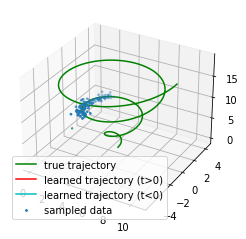

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 500/5000 tr_elbo:-3578.05
Iter:0  lhood: 3614.58  kl_z:261.11    kl_w:   15.15
Epoch: 501/5000 tr_elbo:-3491.28
Iter:0  lhood: 3459.67  kl_z:57.48     kl_w:   15.15
Epoch: 502/5000 tr_elbo:-3545.44
Iter:0  lhood: 3535.45  kl_z:38.58     kl_w:   15.15
Epoch: 503/5000 tr_elbo:-3660.07
Iter:0  lhood: 3467.93  kl_z:9.24      kl_w:   15.15
Epoch: 504/5000 tr_elbo:-3699.21
Iter:0  lhood: 3472.08  kl_z:60.93     kl_w:   15.15
Epoch: 505/5000 tr_elbo:-3665.45
Iter:0  lhood: 3264.38  kl_z:58.62     kl_w:   15.15
Epoch: 506/5000 tr_elbo:-3206.87
Iter:0  lhood: 3598.37  kl_z:109.95    kl_w:   15.15
Epoch: 507/5000 tr_elbo:-3697.01
Iter:0  lhood: 3608.02  kl_z:170.05    kl_w:   15.15
Epoch: 508/5000 tr_elbo:-3517.90
Iter:0  lhood: 3522.77  kl_z:159.14    kl_w:   15.15
Epoch: 509/5000 tr_elbo:-3447.35
Iter:0  lhood: 3196.82  kl_z:-44.31    kl_w:   15.15


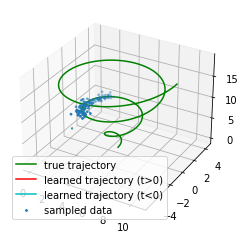

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 510/5000 tr_elbo:-3023.05
Iter:0  lhood: 3554.99  kl_z:154.55    kl_w:   15.15
Epoch: 511/5000 tr_elbo:-3345.44
Iter:0  lhood: 3709.30  kl_z:288.76    kl_w:   15.15
Epoch: 512/5000 tr_elbo:-3487.64
Iter:0  lhood: 3601.32  kl_z:100.65    kl_w:   15.15
Epoch: 513/5000 tr_elbo:-3755.37
Iter:0  lhood: 3200.38  kl_z:26.31     kl_w:   15.15
Epoch: 514/5000 tr_elbo:-2888.86
Iter:0  lhood: 3584.92  kl_z:52.27     kl_w:   15.15
Epoch: 515/5000 tr_elbo:-3789.59
Iter:0  lhood: 3477.26  kl_z:36.78     kl_w:   15.15
Epoch: 516/5000 tr_elbo:-3503.17
Iter:0  lhood: 3644.07  kl_z:101.95    kl_w:   15.15
Epoch: 517/5000 tr_elbo:-3742.44
Iter:0  lhood: 3708.95  kl_z:212.29    kl_w:   15.15
Epoch: 518/5000 tr_elbo:-3642.61
Iter:0  lhood: 3580.63  kl_z:161.09    kl_w:   15.15
Epoch: 519/5000 tr_elbo:-2965.05
Iter:0  lhood: 3613.18  kl_z:115.62    kl_w:   15.15


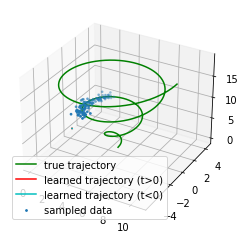

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 520/5000 tr_elbo:-3691.12
Iter:0  lhood: 3633.44  kl_z:140.95    kl_w:   15.15
Epoch: 521/5000 tr_elbo:-3661.90
Iter:0  lhood: 3519.00  kl_z:45.81     kl_w:   15.15
Epoch: 522/5000 tr_elbo:-3587.58
Iter:0  lhood: 3673.94  kl_z:223.64    kl_w:   15.15
Epoch: 523/5000 tr_elbo:-3557.81
Iter:0  lhood: 3689.33  kl_z:174.60    kl_w:   15.15
Epoch: 524/5000 tr_elbo:-3746.69
Iter:0  lhood: 3640.79  kl_z:59.60     kl_w:   15.15
Epoch: 525/5000 tr_elbo:-3811.56
Iter:0  lhood: 3479.46  kl_z:56.14     kl_w:   15.15
Epoch: 526/5000 tr_elbo:-3283.10
Iter:0  lhood: 3514.81  kl_z:91.98     kl_w:   15.15
Epoch: 527/5000 tr_elbo:-3550.69
Iter:0  lhood: 3714.70  kl_z:163.29    kl_w:   15.15
Epoch: 528/5000 tr_elbo:-3784.28
Iter:0  lhood: 3575.53  kl_z:30.59     kl_w:   15.15
Epoch: 529/5000 tr_elbo:-3789.24
Iter:0  lhood: 3776.36  kl_z:266.82    kl_w:   15.15


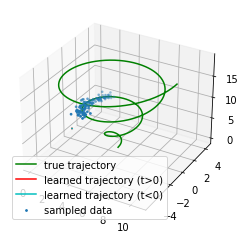

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 530/5000 tr_elbo:-3485.54
Iter:0  lhood: 3702.00  kl_z:70.27     kl_w:   15.15
Epoch: 531/5000 tr_elbo:-3776.53
Iter:0  lhood: 3834.53  kl_z:320.45    kl_w:   15.15
Epoch: 532/5000 tr_elbo:-3482.87
Iter:0  lhood: 3570.68  kl_z:73.39     kl_w:   15.15
Epoch: 533/5000 tr_elbo:-3414.95
Iter:0  lhood: 3707.82  kl_z:83.51     kl_w:   15.15
Epoch: 534/5000 tr_elbo:-3925.76
Iter:0  lhood: 3761.79  kl_z:175.65    kl_w:   15.15
Epoch: 535/5000 tr_elbo:-3841.53
Iter:0  lhood: 3739.76  kl_z:164.34    kl_w:   15.15
Epoch: 536/5000 tr_elbo:-3840.44
Iter:0  lhood: 3713.39  kl_z:154.72    kl_w:   15.15
Epoch: 537/5000 tr_elbo:-3757.11
Iter:0  lhood: 3652.04  kl_z:108.08    kl_w:   15.15
Epoch: 538/5000 tr_elbo:-3757.23
Iter:0  lhood: 3740.53  kl_z:100.28    kl_w:   15.15
Epoch: 539/5000 tr_elbo:-3749.79
Iter:0  lhood: 3832.05  kl_z:201.15    kl_w:   15.15


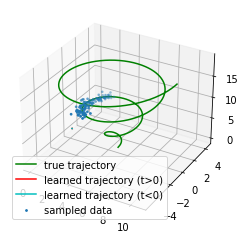

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 540/5000 tr_elbo:-3839.73
Iter:0  lhood: 3824.56  kl_z:242.11    kl_w:   15.15
Epoch: 541/5000 tr_elbo:-3529.51
Iter:0  lhood: 3799.31  kl_z:105.62    kl_w:   15.15
Epoch: 542/5000 tr_elbo:-3844.69
Iter:0  lhood: 3661.18  kl_z:88.13     kl_w:   15.15
Epoch: 543/5000 tr_elbo:-3587.46
Iter:0  lhood: 3795.85  kl_z:234.55    kl_w:   15.15
Epoch: 544/5000 tr_elbo:-3718.79
Iter:0  lhood: 3781.02  kl_z:152.46    kl_w:   15.16
Epoch: 545/5000 tr_elbo:-3870.36
Iter:0  lhood: 3881.26  kl_z:224.94    kl_w:   15.16
Epoch: 546/5000 tr_elbo:-3672.83
Iter:0  lhood: 3850.47  kl_z:191.13    kl_w:   15.16
Epoch: 547/5000 tr_elbo:-3917.03
Iter:0  lhood: 3755.33  kl_z:102.54    kl_w:   15.16
Epoch: 548/5000 tr_elbo:-3780.51
Iter:0  lhood: 3834.97  kl_z:148.45    kl_w:   15.16
Epoch: 549/5000 tr_elbo:-3832.87
Iter:0  lhood: 3719.98  kl_z:20.64     kl_w:   15.16


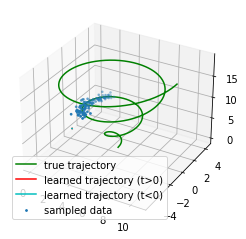

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 550/5000 tr_elbo:-3902.87
Iter:0  lhood: 3716.43  kl_z:1.62      kl_w:   15.16
Epoch: 551/5000 tr_elbo:-3875.75
Iter:0  lhood: 3900.92  kl_z:181.72    kl_w:   15.16
Epoch: 552/5000 tr_elbo:-3852.35
Iter:0  lhood: 3834.62  kl_z:65.61     kl_w:   15.16
Epoch: 553/5000 tr_elbo:-3881.49
Iter:0  lhood: 3752.71  kl_z:20.53     kl_w:   15.16
Epoch: 554/5000 tr_elbo:-3939.85
Iter:0  lhood: 3686.34  kl_z:86.48     kl_w:   15.16
Epoch: 555/5000 tr_elbo:-3734.47
Iter:0  lhood: 3705.87  kl_z:87.82     kl_w:   15.16
Epoch: 556/5000 tr_elbo:-3533.20
Iter:0  lhood: 3642.34  kl_z:-14.14    kl_w:   15.16
Epoch: 557/5000 tr_elbo:-3766.81
Iter:0  lhood: 3762.69  kl_z:107.52    kl_w:   15.16
Epoch: 558/5000 tr_elbo:-3913.94
Iter:0  lhood: 3720.52  kl_z:47.23     kl_w:   15.16
Epoch: 559/5000 tr_elbo:-3757.84
Iter:0  lhood: 3823.45  kl_z:35.06     kl_w:   15.16


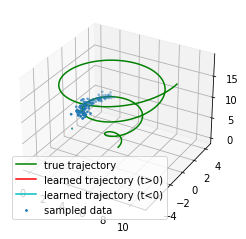

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 560/5000 tr_elbo:-4080.47
Iter:0  lhood: 3912.54  kl_z:139.62    kl_w:   15.16
Epoch: 561/5000 tr_elbo:-3895.45
Iter:0  lhood: 4002.50  kl_z:317.65    kl_w:   15.16
Epoch: 562/5000 tr_elbo:-3763.56
Iter:0  lhood: 3725.27  kl_z:61.35     kl_w:   15.16
Epoch: 563/5000 tr_elbo:-3838.89
Iter:0  lhood: 3827.39  kl_z:91.02     kl_w:   15.16
Epoch: 564/5000 tr_elbo:-3867.39
Iter:0  lhood: 3841.70  kl_z:81.10     kl_w:   15.16
Epoch: 565/5000 tr_elbo:-3742.67
Iter:0  lhood: 3893.21  kl_z:68.56     kl_w:   15.16
Epoch: 566/5000 tr_elbo:-4081.10
Iter:0  lhood: 3882.90  kl_z:172.37    kl_w:   15.16
Epoch: 567/5000 tr_elbo:-3903.86
Iter:0  lhood: 3689.44  kl_z:-11.32    kl_w:   15.16
Epoch: 568/5000 tr_elbo:-3838.87
Iter:0  lhood: 3820.57  kl_z:98.86     kl_w:   15.16
Epoch: 569/5000 tr_elbo:-3940.26
Iter:0  lhood: 3857.42  kl_z:105.23    kl_w:   15.16


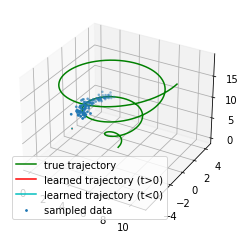

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 570/5000 tr_elbo:-4015.48
Iter:0  lhood: 4037.10  kl_z:280.17    kl_w:   15.16
Epoch: 571/5000 tr_elbo:-3771.01
Iter:0  lhood: 3986.04  kl_z:127.26    kl_w:   15.16
Epoch: 572/5000 tr_elbo:-4078.84
Iter:0  lhood: 4007.94  kl_z:400.80    kl_w:   15.16
Epoch: 573/5000 tr_elbo:-2976.97
Iter:0  lhood: 3813.14  kl_z:167.35    kl_w:   15.16
Epoch: 574/5000 tr_elbo:-3712.08
Iter:0  lhood: 3977.79  kl_z:141.91    kl_w:   15.16
Epoch: 575/5000 tr_elbo:-4025.37
Iter:0  lhood: 3862.09  kl_z:43.35     kl_w:   15.16
Epoch: 576/5000 tr_elbo:-4045.56
Iter:0  lhood: 4024.27  kl_z:197.45    kl_w:   15.16
Epoch: 577/5000 tr_elbo:-4058.32
Iter:0  lhood: 4001.21  kl_z:119.08    kl_w:   15.16
Epoch: 578/5000 tr_elbo:-4007.48
Iter:0  lhood: 3838.47  kl_z:8.51      kl_w:   15.16
Epoch: 579/5000 tr_elbo:-3919.15
Iter:0  lhood: 3964.57  kl_z:118.59    kl_w:   15.16


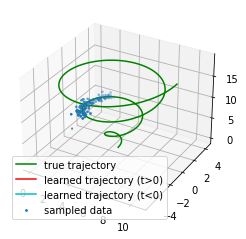

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 580/5000 tr_elbo:-4007.63
Iter:0  lhood: 4067.42  kl_z:278.16    kl_w:   15.16
Epoch: 581/5000 tr_elbo:-3705.94
Iter:0  lhood: 3767.58  kl_z:105.86    kl_w:   15.16
Epoch: 582/5000 tr_elbo:-3079.45
Iter:0  lhood: 3946.58  kl_z:92.72     kl_w:   15.16
Epoch: 583/5000 tr_elbo:-3994.88
Iter:0  lhood: 3968.17  kl_z:29.07     kl_w:   15.16
Epoch: 584/5000 tr_elbo:-4128.70
Iter:0  lhood: 4054.05  kl_z:229.98    kl_w:   15.16
Epoch: 585/5000 tr_elbo:-3938.86
Iter:0  lhood: 3884.29  kl_z:-18.84    kl_w:   15.16
Epoch: 586/5000 tr_elbo:-3967.49
Iter:0  lhood: 3995.27  kl_z:107.36    kl_w:   15.16
Epoch: 587/5000 tr_elbo:-4137.27
Iter:0  lhood: 4029.71  kl_z:112.82    kl_w:   15.16
Epoch: 588/5000 tr_elbo:-4143.52
Iter:0  lhood: 4079.07  kl_z:274.03    kl_w:   15.16
Epoch: 589/5000 tr_elbo:-3953.11
Iter:0  lhood: 4063.87  kl_z:141.15    kl_w:   15.16


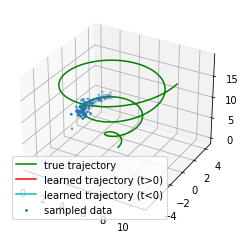

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 590/5000 tr_elbo:-4187.24
Iter:0  lhood: 3878.99  kl_z:63.27     kl_w:   15.16
Epoch: 591/5000 tr_elbo:-4035.95
Iter:0  lhood: 4017.09  kl_z:130.87    kl_w:   15.16
Epoch: 592/5000 tr_elbo:-4111.79
Iter:0  lhood: 4042.91  kl_z:106.97    kl_w:   15.16
Epoch: 593/5000 tr_elbo:-3996.52
Iter:0  lhood: 3909.10  kl_z:37.24     kl_w:   15.16
Epoch: 594/5000 tr_elbo:-3777.82
Iter:0  lhood: 4044.68  kl_z:145.21    kl_w:   15.16
Epoch: 595/5000 tr_elbo:-3926.82
Iter:0  lhood: 4161.40  kl_z:378.92    kl_w:   15.16
Epoch: 596/5000 tr_elbo:-3493.48
Iter:0  lhood: 4084.05  kl_z:162.20    kl_w:   15.16
Epoch: 597/5000 tr_elbo:-4166.46
Iter:0  lhood: 3971.30  kl_z:64.76     kl_w:   15.16
Epoch: 598/5000 tr_elbo:-4008.07
Iter:0  lhood: 4030.02  kl_z:87.73     kl_w:   15.16
Epoch: 599/5000 tr_elbo:-4033.08
Iter:0  lhood: 4069.51  kl_z:155.41    kl_w:   15.16


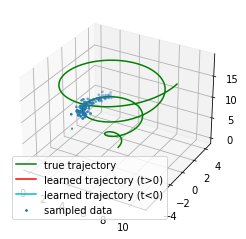

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 600/5000 tr_elbo:-4092.90
Iter:0  lhood: 4153.48  kl_z:227.83    kl_w:   15.16
Epoch: 601/5000 tr_elbo:-3936.29
Iter:0  lhood: 4024.39  kl_z:131.60    kl_w:   15.16
Epoch: 602/5000 tr_elbo:-4063.08
Iter:0  lhood: 4113.95  kl_z:193.66    kl_w:   15.16
Epoch: 603/5000 tr_elbo:-4158.26
Iter:0  lhood: 4034.04  kl_z:62.95     kl_w:   15.16
Epoch: 604/5000 tr_elbo:-4024.99
Iter:0  lhood: 4179.48  kl_z:257.32    kl_w:   15.16
Epoch: 605/5000 tr_elbo:-4095.35
Iter:0  lhood: 4094.52  kl_z:82.83     kl_w:   15.16
Epoch: 606/5000 tr_elbo:-4267.74
Iter:0  lhood: 4056.27  kl_z:30.68     kl_w:   15.16
Epoch: 607/5000 tr_elbo:-4347.32
Iter:0  lhood: 4129.30  kl_z:208.76    kl_w:   15.16
Epoch: 608/5000 tr_elbo:-4059.82
Iter:0  lhood: 4141.74  kl_z:98.03     kl_w:   15.16
Epoch: 609/5000 tr_elbo:-4335.03
Iter:0  lhood: 4106.84  kl_z:116.70    kl_w:   15.16


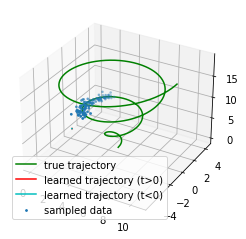

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 610/5000 tr_elbo:-4253.77
Iter:0  lhood: 4006.66  kl_z:-61.06    kl_w:   15.16
Epoch: 611/5000 tr_elbo:-4312.85
Iter:0  lhood: 4156.08  kl_z:220.48    kl_w:   15.16
Epoch: 612/5000 tr_elbo:-4041.20
Iter:0  lhood: 4189.78  kl_z:283.55    kl_w:   15.16
Epoch: 613/5000 tr_elbo:-4112.94
Iter:0  lhood: 4031.81  kl_z:36.19     kl_w:   15.16
Epoch: 614/5000 tr_elbo:-4291.44
Iter:0  lhood: 4163.21  kl_z:176.42    kl_w:   15.16
Epoch: 615/5000 tr_elbo:-3936.04
Iter:0  lhood: 4156.44  kl_z:111.85    kl_w:   15.16
Epoch: 616/5000 tr_elbo:-4260.82
Iter:0  lhood: 4156.38  kl_z:133.91    kl_w:   15.16
Epoch: 617/5000 tr_elbo:-4252.53
Iter:0  lhood: 4171.85  kl_z:174.12    kl_w:   15.16
Epoch: 618/5000 tr_elbo:-4251.78
Iter:0  lhood: 4235.34  kl_z:258.01    kl_w:   15.16
Epoch: 619/5000 tr_elbo:-3870.19
Iter:0  lhood: 3998.14  kl_z:-25.73    kl_w:   15.16


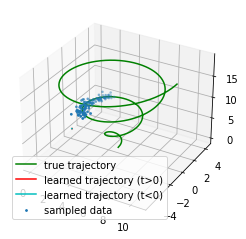

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 620/5000 tr_elbo:-4203.87
Iter:0  lhood: 4158.95  kl_z:81.72     kl_w:   15.16
Epoch: 621/5000 tr_elbo:-4392.93
Iter:0  lhood: 4240.81  kl_z:287.33    kl_w:   15.16
Epoch: 622/5000 tr_elbo:-3936.96
Iter:0  lhood: 4265.38  kl_z:462.28    kl_w:   15.16
Epoch: 623/5000 tr_elbo:-3777.21
Iter:0  lhood: 4048.24  kl_z:65.12     kl_w:   15.16
Epoch: 624/5000 tr_elbo:-4204.57
Iter:0  lhood: 4125.36  kl_z:107.78    kl_w:   15.16
Epoch: 625/5000 tr_elbo:-4232.39
Iter:0  lhood: 4158.76  kl_z:77.83     kl_w:   15.16
Epoch: 626/5000 tr_elbo:-3985.74
Iter:0  lhood: 4218.21  kl_z:121.48    kl_w:   15.16
Epoch: 627/5000 tr_elbo:-4351.27
Iter:0  lhood: 4282.49  kl_z:311.06    kl_w:   15.16
Epoch: 628/5000 tr_elbo:-3950.14
Iter:0  lhood: 4168.95  kl_z:162.75    kl_w:   15.16
Epoch: 629/5000 tr_elbo:-4095.61
Iter:0  lhood: 3981.59  kl_z:-3.86     kl_w:   15.16


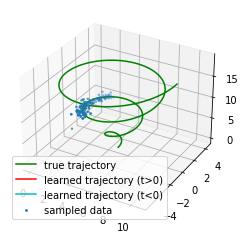

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 630/5000 tr_elbo:-3834.38
Iter:0  lhood: 4145.53  kl_z:55.73     kl_w:   15.16
Epoch: 631/5000 tr_elbo:-4337.94
Iter:0  lhood: 4056.68  kl_z:134.95    kl_w:   15.16
Epoch: 632/5000 tr_elbo:-4116.09
Iter:0  lhood: 4208.18  kl_z:152.85    kl_w:   15.16
Epoch: 633/5000 tr_elbo:-4195.88
Iter:0  lhood: 4208.00  kl_z:81.70     kl_w:   15.16
Epoch: 634/5000 tr_elbo:-4415.18
Iter:0  lhood: 4284.30  kl_z:259.06    kl_w:   15.16
Epoch: 635/5000 tr_elbo:-4099.73
Iter:0  lhood: 4225.16  kl_z:29.32     kl_w:   15.16
Epoch: 636/5000 tr_elbo:-4421.11
Iter:0  lhood: 4201.58  kl_z:94.67     kl_w:   15.16
Epoch: 637/5000 tr_elbo:-4302.75
Iter:0  lhood: 4222.49  kl_z:96.71     kl_w:   15.16
Epoch: 638/5000 tr_elbo:-4442.20
Iter:0  lhood: 4237.00  kl_z:134.42    kl_w:   15.16
Epoch: 639/5000 tr_elbo:-4420.19
Iter:0  lhood: 4306.86  kl_z:158.09    kl_w:   15.16


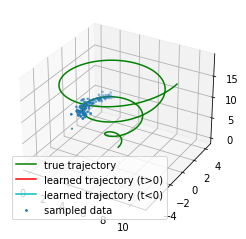

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 640/5000 tr_elbo:-4366.80
Iter:0  lhood: 4272.38  kl_z:146.85    kl_w:   15.16
Epoch: 641/5000 tr_elbo:-4279.60
Iter:0  lhood: 4328.88  kl_z:240.12    kl_w:   15.16
Epoch: 642/5000 tr_elbo:-4288.63
Iter:0  lhood: 3993.12  kl_z:19.01     kl_w:   15.16
Epoch: 643/5000 tr_elbo:-4088.20
Iter:0  lhood: 4257.73  kl_z:68.99     kl_w:   15.16
Epoch: 644/5000 tr_elbo:-4538.16
Iter:0  lhood: 4266.05  kl_z:22.53     kl_w:   15.16
Epoch: 645/5000 tr_elbo:-4444.04
Iter:0  lhood: 4305.01  kl_z:126.64    kl_w:   15.16
Epoch: 646/5000 tr_elbo:-4315.72
Iter:0  lhood: 4213.05  kl_z:-26.49    kl_w:   15.16
Epoch: 647/5000 tr_elbo:-4537.67
Iter:0  lhood: 3978.90  kl_z:40.14     kl_w:   15.16
Epoch: 648/5000 tr_elbo:-3636.06
Iter:0  lhood: 4092.16  kl_z:14.45     kl_w:   15.16
Epoch: 649/5000 tr_elbo:-4202.69
Iter:0  lhood: 4283.14  kl_z:162.14    kl_w:   15.16


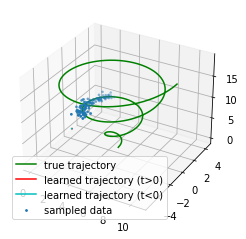

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 650/5000 tr_elbo:-4381.83
Iter:0  lhood: 4274.19  kl_z:103.42    kl_w:   15.16
Epoch: 651/5000 tr_elbo:-4357.43
Iter:0  lhood: 4253.08  kl_z:55.41     kl_w:   15.16
Epoch: 652/5000 tr_elbo:-4468.76
Iter:0  lhood: 4341.73  kl_z:231.76    kl_w:   15.16
Epoch: 653/5000 tr_elbo:-4095.28
Iter:0  lhood: 4325.69  kl_z:173.03    kl_w:   15.16
Epoch: 654/5000 tr_elbo:-4187.47
Iter:0  lhood: 4324.90  kl_z:86.70     kl_w:   15.16
Epoch: 655/5000 tr_elbo:-4583.77
Iter:0  lhood: 4231.54  kl_z:-0.46     kl_w:   15.16
Epoch: 656/5000 tr_elbo:-4579.67
Iter:0  lhood: 4228.80  kl_z:26.71     kl_w:   15.16
Epoch: 657/5000 tr_elbo:-4192.82
Iter:0  lhood: 4221.60  kl_z:24.91     kl_w:   15.16
Epoch: 658/5000 tr_elbo:-4500.91
Iter:0  lhood: 4269.33  kl_z:20.05     kl_w:   15.16
Epoch: 659/5000 tr_elbo:-4463.61
Iter:0  lhood: 4279.66  kl_z:250.76    kl_w:   15.16


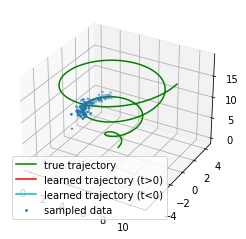

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 660/5000 tr_elbo:-3306.13
Iter:0  lhood: 4358.37  kl_z:201.39    kl_w:   15.16
Epoch: 661/5000 tr_elbo:-3999.75
Iter:0  lhood: 4161.39  kl_z:3.10      kl_w:   15.16
Epoch: 662/5000 tr_elbo:-4357.41
Iter:0  lhood: 4254.41  kl_z:32.68     kl_w:   15.16
Epoch: 663/5000 tr_elbo:-4558.41
Iter:0  lhood: 4399.11  kl_z:327.24    kl_w:   15.16
Epoch: 664/5000 tr_elbo:-3985.25
Iter:0  lhood: 4217.05  kl_z:51.89     kl_w:   15.16
Epoch: 665/5000 tr_elbo:-4401.16
Iter:0  lhood: 4330.22  kl_z:66.04     kl_w:   15.16
Epoch: 666/5000 tr_elbo:-4614.73
Iter:0  lhood: 4386.58  kl_z:101.07    kl_w:   15.16
Epoch: 667/5000 tr_elbo:-4552.68
Iter:0  lhood: 4431.38  kl_z:204.38    kl_w:   15.16
Epoch: 668/5000 tr_elbo:-4385.77
Iter:0  lhood: 4274.13  kl_z:-0.55     kl_w:   15.16
Epoch: 669/5000 tr_elbo:-4495.27
Iter:0  lhood: 4106.42  kl_z:25.91     kl_w:   15.16


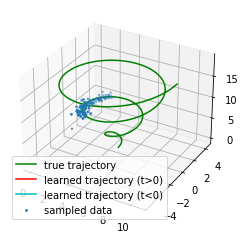

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 670/5000 tr_elbo:-4100.18
Iter:0  lhood: 4373.02  kl_z:143.20    kl_w:   15.16
Epoch: 671/5000 tr_elbo:-4140.80
Iter:0  lhood: 4358.28  kl_z:87.77     kl_w:   15.16
Epoch: 672/5000 tr_elbo:-4646.83
Iter:0  lhood: 4459.67  kl_z:290.67    kl_w:   15.16
Epoch: 673/5000 tr_elbo:-4197.16
Iter:0  lhood: 4305.56  kl_z:188.86    kl_w:   15.16
Epoch: 674/5000 tr_elbo:-4251.37
Iter:0  lhood: 4417.08  kl_z:182.12    kl_w:   15.16
Epoch: 675/5000 tr_elbo:-3992.80
Iter:0  lhood: 4349.21  kl_z:37.86     kl_w:   15.16
Epoch: 676/5000 tr_elbo:-4529.57
Iter:0  lhood: 4355.64  kl_z:49.11     kl_w:   15.16
Epoch: 677/5000 tr_elbo:-4553.64
Iter:0  lhood: 4403.34  kl_z:59.16     kl_w:   15.16
Epoch: 678/5000 tr_elbo:-4696.14
Iter:0  lhood: 4304.57  kl_z:43.72     kl_w:   15.16
Epoch: 679/5000 tr_elbo:-4493.62
Iter:0  lhood: 4273.27  kl_z:70.86     kl_w:   15.16


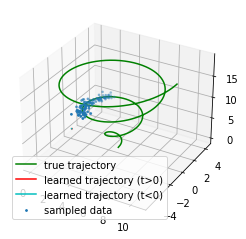

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 680/5000 tr_elbo:-4439.84
Iter:0  lhood: 4322.80  kl_z:-13.13    kl_w:   15.16
Epoch: 681/5000 tr_elbo:-4587.32
Iter:0  lhood: 4466.31  kl_z:306.79    kl_w:   15.16
Epoch: 682/5000 tr_elbo:-4198.54
Iter:0  lhood: 4493.21  kl_z:235.51    kl_w:   15.16
Epoch: 683/5000 tr_elbo:-4402.77
Iter:0  lhood: 4420.72  kl_z:55.22     kl_w:   15.16
Epoch: 684/5000 tr_elbo:-4679.48
Iter:0  lhood: 4488.27  kl_z:199.15    kl_w:   15.16
Epoch: 685/5000 tr_elbo:-4442.82
Iter:0  lhood: 4266.39  kl_z:92.69     kl_w:   15.16
Epoch: 686/5000 tr_elbo:-4292.55
Iter:0  lhood: 4414.45  kl_z:48.38     kl_w:   15.16
Epoch: 687/5000 tr_elbo:-4707.94
Iter:0  lhood: 4453.82  kl_z:151.80    kl_w:   15.16
Epoch: 688/5000 tr_elbo:-4573.96
Iter:0  lhood: 4463.02  kl_z:189.13    kl_w:   15.16
Epoch: 689/5000 tr_elbo:-4552.29
Iter:0  lhood: 4440.66  kl_z:56.88     kl_w:   15.16


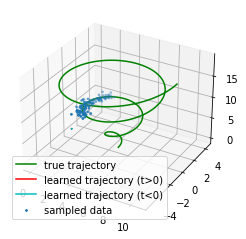

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 690/5000 tr_elbo:-4701.89
Iter:0  lhood: 4480.49  kl_z:146.13    kl_w:   15.16
Epoch: 691/5000 tr_elbo:-4637.77
Iter:0  lhood: 4299.79  kl_z:36.43     kl_w:   15.16
Epoch: 692/5000 tr_elbo:-4312.34
Iter:0  lhood: 4524.19  kl_z:259.28    kl_w:   15.16
Epoch: 693/5000 tr_elbo:-4191.00
Iter:0  lhood: 4528.76  kl_z:235.54    kl_w:   15.16
Epoch: 694/5000 tr_elbo:-4423.85
Iter:0  lhood: 4505.26  kl_z:202.55    kl_w:   15.16
Epoch: 695/5000 tr_elbo:-4640.68
Iter:0  lhood: 4493.20  kl_z:68.91     kl_w:   15.16
Epoch: 696/5000 tr_elbo:-4711.90
Iter:0  lhood: 4511.07  kl_z:104.76    kl_w:   15.16
Epoch: 697/5000 tr_elbo:-4729.58
Iter:0  lhood: 4430.86  kl_z:8.92      kl_w:   15.16
Epoch: 698/5000 tr_elbo:-4533.83
Iter:0  lhood: 4415.70  kl_z:135.37    kl_w:   15.16
Epoch: 699/5000 tr_elbo:-4193.80
Iter:0  lhood: 4419.70  kl_z:16.63     kl_w:   15.16


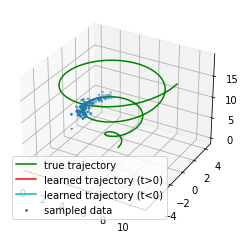

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 700/5000 tr_elbo:-4688.11
Iter:0  lhood: 4442.49  kl_z:43.86     kl_w:   15.16
Epoch: 701/5000 tr_elbo:-4758.51
Iter:0  lhood: 4109.94  kl_z:7.36      kl_w:   15.16
Epoch: 702/5000 tr_elbo:-3978.19
Iter:0  lhood: 4436.91  kl_z:67.81     kl_w:   15.16
Epoch: 703/5000 tr_elbo:-4555.19
Iter:0  lhood: 4348.51  kl_z:-20.14    kl_w:   15.16
Epoch: 704/5000 tr_elbo:-4647.32
Iter:0  lhood: 4463.32  kl_z:13.35     kl_w:   15.16
Epoch: 705/5000 tr_elbo:-4781.81
Iter:0  lhood: 4426.47  kl_z:75.53     kl_w:   15.16
Epoch: 706/5000 tr_elbo:-4609.73
Iter:0  lhood: 4565.03  kl_z:213.78    kl_w:   15.16
Epoch: 707/5000 tr_elbo:-4408.87
Iter:0  lhood: 4437.51  kl_z:66.56     kl_w:   15.16
Epoch: 708/5000 tr_elbo:-4680.28
Iter:0  lhood: 4550.07  kl_z:210.46    kl_w:   15.16
Epoch: 709/5000 tr_elbo:-4285.30
Iter:0  lhood: 4394.76  kl_z:48.89     kl_w:   15.16


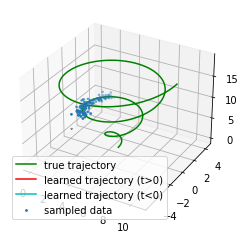

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 710/5000 tr_elbo:-4571.75
Iter:0  lhood: 4574.11  kl_z:181.01    kl_w:   15.16
Epoch: 711/5000 tr_elbo:-4644.83
Iter:0  lhood: 4521.46  kl_z:29.88     kl_w:   15.16
Epoch: 712/5000 tr_elbo:-4865.34
Iter:0  lhood: 4432.03  kl_z:12.77     kl_w:   15.16
Epoch: 713/5000 tr_elbo:-4715.64
Iter:0  lhood: 4600.94  kl_z:381.07    kl_w:   15.16
Epoch: 714/5000 tr_elbo:-4062.84
Iter:0  lhood: 4504.62  kl_z:71.54     kl_w:   15.16
Epoch: 715/5000 tr_elbo:-4759.87
Iter:0  lhood: 4505.86  kl_z:93.60     kl_w:   15.16
Epoch: 716/5000 tr_elbo:-4735.00
Iter:0  lhood: 4490.43  kl_z:16.94     kl_w:   15.16
Epoch: 717/5000 tr_elbo:-4569.56
Iter:0  lhood: 4485.21  kl_z:33.45     kl_w:   15.16
Epoch: 718/5000 tr_elbo:-4782.28
Iter:0  lhood: 4517.80  kl_z:61.82     kl_w:   15.16
Epoch: 719/5000 tr_elbo:-4606.75
Iter:0  lhood: 4534.04  kl_z:115.88    kl_w:   15.16


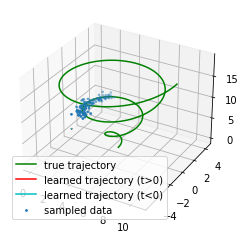

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 720/5000 tr_elbo:-4738.75
Iter:0  lhood: 4468.28  kl_z:48.02     kl_w:   15.16
Epoch: 721/5000 tr_elbo:-4685.37
Iter:0  lhood: 4536.70  kl_z:55.34     kl_w:   15.16
Epoch: 722/5000 tr_elbo:-4844.15
Iter:0  lhood: 4511.94  kl_z:11.98     kl_w:   15.16
Epoch: 723/5000 tr_elbo:-4866.26
Iter:0  lhood: 4433.49  kl_z:60.90     kl_w:   15.16
Epoch: 724/5000 tr_elbo:-4494.63
Iter:0  lhood: 4499.44  kl_z:-10.98    kl_w:   15.16
Epoch: 725/5000 tr_elbo:-4780.37
Iter:0  lhood: 4590.56  kl_z:168.28    kl_w:   15.16
Epoch: 726/5000 tr_elbo:-4332.15
Iter:0  lhood: 4464.65  kl_z:-23.97    kl_w:   15.16
Epoch: 727/5000 tr_elbo:-4752.10
Iter:0  lhood: 4521.16  kl_z:82.91     kl_w:   15.16
Epoch: 728/5000 tr_elbo:-4798.72
Iter:0  lhood: 4401.87  kl_z:-56.05    kl_w:   15.16
Epoch: 729/5000 tr_elbo:-4591.93
Iter:0  lhood: 4383.16  kl_z:127.60    kl_w:   15.16


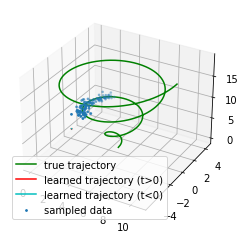

Stored ckpt at ./ckpt_ode2vae.pth
Epoch: 730/5000 tr_elbo:-3844.56
Stored ckpt at ./ckpt_ode2vae.pth
Training complete after 731 iters.


In [5]:
Nepoch = 5000
eta = 0.0001
train_dir = './'
q = 3
Hf = 30
He = 30
Hd = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

loss_meter = RunningAverageMeter()
ode2vae = ODE2VAE(q, Hf, He, Hd).to(device)
optimizer = torch.optim.Adam(ode2vae.parameters(), lr=eta)

if train_dir is not None:
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    ckpt_path = os.path.join(train_dir, 'ckpt_3ds_ode2vae.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        ode2vae.load_state_dict(checkpoint['ode2vae_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        orig_trajs = checkpoint['orig_trajs']
        samp_trajs = checkpoint['samp_trajs']
        orig_ts = checkpoint['orig_ts']
        samp_ts = checkpoint['samp_ts']
        print('Loaded ckpt from {}'.format(ckpt_path))

try:
    for ep in range(1, Nepoch+1):
        L = 1
        for i, local_batch in enumerate(train_loader):
            minibatch = local_batch[0].to(device)
            ts = torch.from_numpy(samp_ts).float().to(device)
            elbo, lhood, kl_z, kl_w = ode2vae(minibatch, ts, len(train_loader), L=L, inst_enc=True, method='dopri5')[4:]
            tr_loss = -elbo
            optimizer.zero_grad()
            tr_loss.backward()
            optimizer.step()
            print('Iter:{:<2d} lhood:{:8.2f}  kl_z:{:<8.2f}  kl_w:{:8.2f}'.\
                format(i, lhood.item(), kl_z.item(), kl_w.item()))

        if ep % 10 == 0:
            with torch.no_grad():
                xs_pos, xs_neg = ode2vae.mean_rec(torch.from_numpy(samp_trajs[0]).float().unsqueeze(0).to(device), method='dopri5')
                xs_pos = xs_pos.cpu().numpy()
                xs_neg = xs_neg.cpu().numpy()
                orig_traj = orig_trajs[0]
                samp_traj = samp_trajs[0]

                plt.figure()
                ax = plt.axes(projection='3d')
                ax.plot3D(orig_traj[:, 0], orig_traj[:, 1], orig_traj[:, 2],
                        'g', label='true trajectory')
                ax.plot3D(xs_pos[:, 0], xs_pos[:, 1], xs_pos[:, 2], 'r',
                        label='learned trajectory (t>0)')
                ax.plot3D(xs_neg[:, 0], xs_neg[:, 1], xs_neg[:, 2], 'c',
                        label='learned trajectory (t<0)')
                ax.scatter3D(samp_traj[:, 0], samp_traj[:, 1], samp_traj[:, 2], label='sampled data', s=3)
                plt.legend()
                plt.show()
                plt.close()

            if train_dir is not None:
                ckpt_path = os.path.join(train_dir, 'ckpt_3ds_ode2vae.pth')
                torch.save({
                    'ode2vae_state_dict': ode2vae.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'orig_trajs': orig_trajs,
                    'samp_trajs': samp_trajs,
                    'orig_ts': orig_ts,
                    'samp_ts': samp_ts,
                }, ckpt_path)
                print('Stored ckpt at {}'.format(ckpt_path))

        print('Epoch:{:4d}/{:4d} tr_elbo:{:8.2f}'.format(ep, Nepoch, tr_loss.item()))

except KeyboardInterrupt:
    if train_dir is not None:
        ckpt_path = os.path.join(train_dir, 'ckpt_3ds_ode2vae.pth')
        torch.save({
            'ode2vae_state_dict': ode2vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'orig_ts': orig_ts,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(ep))

plt.close('all')

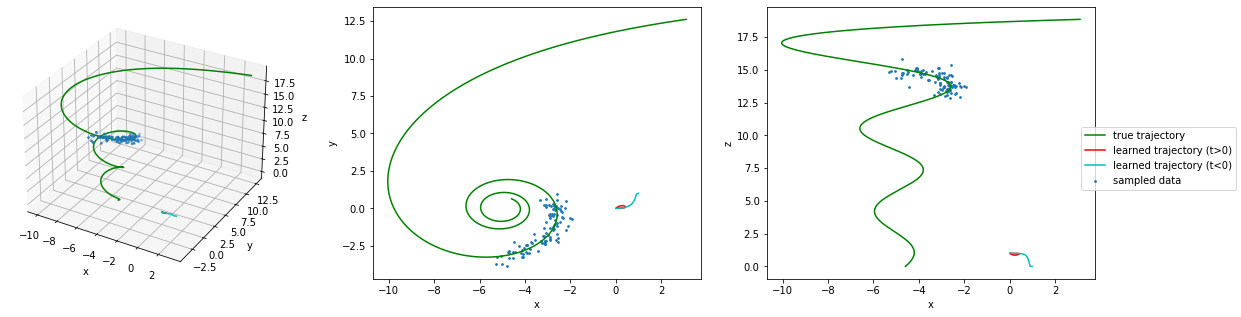

In [6]:
with torch.no_grad():
    xs_pos, xs_neg = ode2vae.mean_rec(torch.from_numpy(samp_trajs).float().to(device), method='dopri5')
    xs_pos = xs_pos.cpu().numpy()
    xs_neg = xs_neg.cpu().numpy()
    orig_traj = orig_trajs[0]
    samp_traj = samp_trajs[0]

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot3D(orig_traj[:, 0], orig_traj[:, 1], orig_traj[:, 2],
            'g', label='true trajectory')
    ax.plot3D(xs_pos[:, 0], xs_pos[:, 1], xs_pos[:, 2], 'r',
            label='learned trajectory (t>0)')
    ax.plot3D(xs_neg[:, 0], xs_neg[:, 1], xs_neg[:, 2], 'c',
            label='learned trajectory (t<0)')
    ax.scatter3D(samp_traj[:, 0], samp_traj[:, 1], samp_traj[:, 2], label='sampled data', s=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(orig_traj[:, 0], orig_traj[:, 1], 'g')
    ax.plot(xs_pos[:, 0], xs_pos[:, 1], 'r')
    ax.plot(xs_neg[:, 0], xs_neg[:, 1], 'c')
    ax.scatter(samp_traj[:, 0], samp_traj[:, 1], s=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(orig_traj[:, 0], orig_traj[:, 2], 'g')
    ax.plot(xs_pos[:, 0], xs_pos[:, 2], 'r')
    ax.plot(xs_neg[:, 0], xs_neg[:, 2], 'c')
    ax.scatter(samp_traj[:, 0], samp_traj[:, 2], s=3)
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    fig.legend(loc=7)
    plt.show()
    plt.close()